In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import questplus
from statsmodels.stats.proportion import proportion_confint
from tqdm import tqdm

from scipy.optimize import minimize
from scipy.special import erf

In [2]:
subject_id = "001"
data_path = os.path.join("..", "data", "raw")

# 1. Load Data

In [3]:
# Load all session data files for the given subject ID
data = {}
staircases = {}
for root, dirs, files in os.walk(data_path):
    session_id = os.path.basename(root) 
    if session_id[:5] != f"ID{subject_id}":
        continue
    for file in files: 
        if file.startswith(f"ID{subject_id}") and file.endswith(".csv"):
            if file.endswith("_trials.csv"):
                continue
            file_path = os.path.join(root, file)
            print(file_path)
            try: 
                session_df = pd.read_csv(file_path)
            except pd.errors.ParserError:
                print(f"Warning: {file_path} has bad lines, skip bad lines.")
                session_df = pd.read_csv(file_path, on_bad_lines='skip')
            data[session_id] = session_df
        
        if file.startswith("questplus_staircase") and file.endswith(".json"):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:  # Open in text mode
                text = f.read()  # Load JSON data
                staircase = questplus.qp.QuestPlus.from_json(text)
                key = file[20:-5] 
                if session_id not in staircases:
                    staircases[session_id] = {}
                staircases[session_id][key] = staircase
print("Number of sessions loaded:", len(data))

..\data\raw\ID001S01_Rothe_Kai_2025-12-24_15h53.55.773\ID001S01_Rothe_Kai_2025-12-24_15h53.55.773.csv
..\data\raw\ID001S02_Rothe_Kai_2025-12-24_16h48.09.730\ID001S02_Rothe_Kai_2025-12-24_16h48.09.730.csv
..\data\raw\ID001S03_Rothe_Kai_2026-01-05_20h22.26.755\ID001S03_Rothe_Kai_2026-01-05_20h22.26.755.csv
..\data\raw\ID001S04_Rothe_Kai_2026-01-05_20h47.22.582\ID001S04_Rothe_Kai_2026-01-05_20h47.22.582.csv
..\data\raw\ID001S05_Rothe_Kai_2026-01-06_17h01.06.114\ID001S05_Rothe_Kai_2026-01-06_17h01.06.114.csv
..\data\raw\ID001S06_Rothe_Kai_2026-01-07_11h48.59.005\ID001S06_Rothe_Kai_2026-01-07_11h48.59.005.csv
..\data\raw\ID001S07_Rothe_Kai_2026-01-08_15h16.35.212\ID001S07_Rothe_Kai_2026-01-08_15h16.35.212.csv
..\data\raw\ID001S08_Rothe_Kai_2026-01-08_15h50.51.583\ID001S08_Rothe_Kai_2026-01-08_15h50.51.583.csv
Number of sessions loaded: 8


In [4]:
print(session_df.head())

   thisN  thisTrialN  thisRepN  n_row  displacement_cols  orientation_degrees  \
0    NaN         NaN       NaN    NaN                NaN                  NaN   
1    NaN         NaN       NaN    NaN                NaN                  NaN   
2    0.0         0.0       0.0   12.0               1.75                 90.0   
3    1.0         1.0       0.0    1.0               4.25                 90.0   
4    2.0         2.0       0.0   12.0               3.25                  0.0   

   session  stimulus_frames  stimulus_duration_s  x_eccentricity_degrees  ...  \
0        8              NaN                  NaN                     NaN  ...   
1        8              NaN                  NaN                     NaN  ...   
2        8              6.0                  0.1                    -5.0  ...   
3        8              6.0                  0.1                    -5.0  ...   
4        8              6.0                  0.1                    -5.0  ...   

   skip_training skip_test

In [5]:
qp_results = {}
for session_id in staircases.keys():
    print(f"Results for session {session_id}:")
    if session_id not in qp_results:
        qp_results[session_id] = {}
    for key, staircase in staircases[session_id].items():
        params_dict = staircase.param_estimate
        mean, std, lapse_rate = params_dict['mean'], params_dict['sd'], params_dict['lapse_rate']
        qp_results[session_id][key] = (mean, std, lapse_rate)
        print(f"   - Staircase {key}:\n         Mean = {mean}\n         Std = {std}\n         Lapse Rate = {lapse_rate}")

Results for session ID001S01_Rothe_Kai_2025-12-24_15h53.55.773:
   - Staircase n_row=12_orientation_degrees=0:
         Mean = -0.9998894698238495
         Std = 0.7660078958193767
         Lapse Rate = 0.004226336201079867
   - Staircase n_row=1_orientation_degrees=0:
         Mean = 0.3538412351281374
         Std = 2.842590281412212
         Lapse Rate = 0.17854738580948018
Results for session ID001S02_Rothe_Kai_2025-12-24_16h48.09.730:
   - Staircase n_row=12_orientation_degrees=0:
         Mean = -0.7378719141814872
         Std = 0.6247482061112483
         Lapse Rate = 0.002463109411775605
   - Staircase n_row=1_orientation_degrees=0:
         Mean = -1.6243723949381552
         Std = 3.471299288708938
         Lapse Rate = 0.06225499307666916
Results for session ID001S03_Rothe_Kai_2026-01-05_20h22.26.755:
   - Staircase n_row=12_orientation_degrees=0:
         Mean = -0.9635820656058242
         Std = 0.7360124820444511
         Lapse Rate = 0.0041765984725787315
   - Staircase

# 2. Preliminary: Visualize QUEST+ results 

In [6]:
def cumulative_gaussian(x, mu, sigma, lapse_rate):
    # https://statproofbook.github.io/P/norm-cdf.html 
    # lapse rate like in questplus, see https://github.com/hoechenberger/questplus/blob/main/questplus/psychometric_function.py
    return lapse_rate + (1 - 2 * lapse_rate) * 0.5 * (1 + erf((x - mu) / (sigma * np.sqrt(2))))

In [7]:
def cumulative_gaussian_2(x, mu, sigma, lapse_rate_left, lapse_rate_right):
    # https://statproofbook.github.io/P/norm-cdf.html 
    # lapse rate like in questplus, see https://github.com/hoechenberger/questplus/blob/main/questplus/psychometric_function.py
    return lapse_rate_left + (1 - lapse_rate_left - lapse_rate_right) * 0.5 * (1 + erf((x - mu) / (sigma * np.sqrt(2))))

In [8]:
def BIC(n, k, ll):
    """ Calculate Bayesian Information Criterion (BIC)
    
    Parameters:
    n : int
        Number of data points
    k : int
        Number of parameters in the model
    ll : float
        Log-likelihood of the model
    """
    return k * np.log(n) - 2 * ll

def AIC(k, ll):
    """ Calculate Akaike Information Criterion (AIC)
    
    Parameters:
    k : int
        Number of parameters in the model
    ll : float
        Log-likelihood of the model
    """
    return 2 * k - 2 * ll

In [9]:
def psychometric_plot(probs, probs_err_lower, probs_err_upper, disp_selected, n_data_points, mu, sigma, lapse_rate, size_scale=35, title = None, bootstrap_params = None, verbose = True, lapse_rate_right = None):
    # assure correct error bars
    if np.any(probs_err_lower < 0) or np.any(probs_err_upper < 0):
        print("Warning: Negative error bars detected:")
        print(probs_err_lower[probs_err_lower < 0], probs_err_upper[probs_err_upper < 0])
        print("Clipping to zero.")
        probs_err_lower = np.clip(probs_err_lower, 0, None)
        probs_err_upper = np.clip(probs_err_upper, 0, None)
    if np.any(probs_err_lower > 1) or np.any(probs_err_upper > 1):
        print("Warning: Error bars greater than 100% detected:")
        print(probs_err_lower[probs_err_lower > 1], probs_err_upper[probs_err_upper > 1])
        print("Clipping to 100%.")
        probs_err_lower = np.clip(probs_err_lower, None, 1)
        probs_err_upper = np.clip(probs_err_upper, None, 1)
    
    # plot the data and fit
    plt.figure()
    plt.title(title)
    
    # plot data points with error bars
    plt.errorbar(disp_selected, probs * 100, yerr=[probs_err_lower * 100, probs_err_upper * 100], color='darkgrey', fmt='none', linestyle='None', capsize=3, capthick=2, elinewidth=2, alpha=0.3, zorder=1)
    sizes = np.sqrt(n_data_points) * size_scale  # Scale sizes for better visibility
    plt.scatter(disp_selected, probs * 100, s=sizes, color='blue', alpha=0.8, zorder=3, linewidth=0)
    unique_data_points = np.unique(n_data_points)
    data_points_to_plot = [0, round(len(unique_data_points) / 2), len(unique_data_points)-1] if len(unique_data_points) >= 4 else range(len(unique_data_points))
    for i, s in enumerate(unique_data_points): # legend for point sizes
        if i in data_points_to_plot:
            plt.scatter([], [], s=np.sqrt(s) * size_scale, 
                    c='blue', linewidth=0, alpha=1.0, label=f'n = {s}')
    
    # plot psychometric function
    if isinstance(mu, list):
        assert len(mu) >= 3, "mu must be a list of [lower CI, MLE, upper CI]"
        assert len(sigma) >= 3, "sigma must be a list of [lower CI, MLE, upper CI]"
        assert len(lapse_rate) >= 3, "lapse_rate must be a list of [lower CI, MLE, upper CI]"
        mean = mu[1]
        mean_minus = mean - mu[0]
        mean_plus = mu[2] - mean
        std = sigma[1]
        std_minus = std - sigma[0]
        std_plus = sigma[2] - std
        lapse = lapse_rate[1]
        lapse_minus = lapse - lapse_rate[0]
        lapse_plus = lapse_rate[2] - lapse
        if lapse_rate_right is None:
            label = "\n".join([
                rf"$\mu = {mean:.2f}^{{+{mean_plus:.2f}}}_{{-{mean_minus:.2f}}}$",
                rf"$\sigma = {std:.2f}^{{+{std_plus:.2f}}}_{{-{std_minus:.2f}}}$",
                rf"$\delta = {lapse:.2f}^{{+{lapse_plus:.2f}}}_{{-{lapse_minus:.2f}}}$"
            ])
        else:
            lapse_right = lapse_rate_right[1]
            lapse_right_minus = lapse_right - lapse_rate_right[0]
            lapse_right_plus = lapse_rate_right[2] - lapse_right
            label = "\n".join([
                rf"$\mu = {mean:.2f}^{{+{mean_plus:.2f}}}_{{-{mean_minus:.2f}}}$",
                rf"$\sigma = {std:.2f}^{{+{std_plus:.2f}}}_{{-{std_minus:.2f}}}$",
                rf"$\delta_1 = {lapse:.2f}^{{+{lapse_plus:.2f}}}_{{-{lapse_minus:.2f}}}$",
                rf"$\delta_2 = {lapse_right:.2f}^{{+{lapse_right_plus:.2f}}}_{{-{lapse_right_minus:.2f}}}$"
            ])
        label_2 = rf'Bias: ${- 1/2 * mean:.2f}^{{+{1/2 * mean_minus:.2f}}}_{{-{1/2 * mean_plus:.2f}}}$'
    else:
        mean = mu
        std = sigma
        lapse = lapse_rate
        label = "\n".join([
            rf"$\mu = {mean:.2f}$",
            rf"$\sigma = {std:.2f}$",
            rf"$\delta = {lapse:.2f}$"
        ])
        label_2 = rf'Bias: ${- 1/2 * mean:.2f}$'
    
    x_fit = np.linspace(-3.5, 3.5, 100)
    if lapse_rate_right is not None:
        y_fit = cumulative_gaussian_2(x_fit, mean, std, lapse, lapse_right)
    else:
        y_fit = cumulative_gaussian(x_fit, mean, std, lapse)
    plt.plot(
        x_fit, 
        y_fit * 100, 
        label=label, 
        color='black', 
        linewidth=3, 
        zorder=2, 
        alpha=1.0
    )
    if bootstrap_params is not None:
        for params in bootstrap_params:
            if lapse_rate_right is not None:
                y_fit_ = cumulative_gaussian_2(x_fit, params[0], params[1], params[2], params[3])
            else:
                y_fit_ = cumulative_gaussian(x_fit, params[0], params[1], params[2])
            plt.plot(x_fit, y_fit_ * 100, 'grey', linewidth = 2, zorder = 0, alpha = 0.1 * (1000 / len(bootstrap_params)))
    
    plt.xlabel('Horizontal displacement (columns)')
    plt.ylabel('Probability of response')
    plt.xlim(-3.5, 3.5)
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    
    # plot bias lines
    
    plt.axvline(mean, ymin = 0., ymax = (50 - y_min) / (y_max - y_min), color='red', linestyle='--', label=label_2, linewidth=3, zorder=1, alpha = 0.8)
    plt.axhline(50, xmin= 0., xmax = (mean - x_min) / (x_max - x_min), color='red', linestyle='--', linewidth=3, zorder=1, alpha = 0.8)
    
    plt.ylim([-3, 103])
    plt.yticks([0, 50, 100], ['0%', '50%', '100%'])
    plt.legend(loc = "upper left", fontsize = 'medium', scatterpoints=1,
          labelspacing=1.,    # Much more vertical space
          borderpad=1.,
          handletextpad=1.,   # Space between marker and text
          frameon=True)
    
    if verbose:
        plt.show()

In [239]:
def psychometric_plot_2(probs, probs_err_lower, probs_err_upper, disp_selected, n_data_points, mu, sigma, lapse_rate, size_scale=20, title = None, bootstrap_params = None, verbose = True, lapse_rate_right = None, figsize = None, dpi = 300, show_legend = True):
    plt.rcParams.update({'font.size': 16})
    
    # assure correct error bars
    if np.any(probs_err_lower < 0) or np.any(probs_err_upper < 0):
        print("Warning: Negative error bars detected:")
        print(probs_err_lower[probs_err_lower < 0], probs_err_upper[probs_err_upper < 0])
        print("Clipping to zero.")
        probs_err_lower = np.clip(probs_err_lower, 0, None)
        probs_err_upper = np.clip(probs_err_upper, 0, None)
    if np.any(probs_err_lower > 1) or np.any(probs_err_upper > 1):
        print("Warning: Error bars greater than 100% detected:")
        print(probs_err_lower[probs_err_lower > 1], probs_err_upper[probs_err_upper > 1])
        print("Clipping to 100%.")
        probs_err_lower = np.clip(probs_err_lower, None, 1)
        probs_err_upper = np.clip(probs_err_upper, None, 1)
    
    # plot the data and fit
    plt.figure(figsize = figsize, dpi=dpi)
    plt.title(title)
    
    # plot psychometric function
    if isinstance(mu, list):
        assert len(mu) >= 3, "mu must be a list of [lower CI, MLE, upper CI]"
        assert len(sigma) >= 3, "sigma must be a list of [lower CI, MLE, upper CI]"
        assert len(lapse_rate) >= 3, "lapse_rate must be a list of [lower CI, MLE, upper CI]"
        mean = mu[1]
        std = sigma[1]
        lapse = lapse_rate[1]
        if lapse_rate_right is not None:
            lapse_right = lapse_rate_right[1]
    else:
        mean = mu
        std = sigma
        lapse = lapse_rate

    x_fit = np.linspace(-3.5, 3.5, 100)
    if lapse_rate_right is not None:
        y_fit = cumulative_gaussian_2(x_fit, mean, std, lapse, lapse_right)
    else:
        y_fit = cumulative_gaussian(x_fit, mean, std, lapse)
    plt.plot(
        x_fit, 
        y_fit * 100, 
        label=r"ML Fit", 
        color='black', 
        linewidth=3, 
        zorder=2, 
        alpha=1.0
    )
    if bootstrap_params is not None:
        y_fits = []
        for params in bootstrap_params:
            if lapse_rate_right is not None:
                y_fit_ = cumulative_gaussian_2(x_fit, params[0], params[1], params[2], params[3])
            else:
                y_fit_ = cumulative_gaussian(x_fit, params[0], params[1], params[2])
            y_fits.append(y_fit_ * 100) 
        y_fits = np.array(y_fits)
        lower_y = np.percentile(y_fits, 2.5, axis=0)
        upper_y = np.percentile(y_fits, 97.5, axis=0)
        plt.fill_between(x_fit, lower_y, upper_y, color='black', zorder = 0, alpha = 0.15, edgecolor="none")
        
    plt.xlabel('Horizontal displacement [columns]', fontsize = 16)
    plt.ylabel("Subject response [%]", fontsize = 16)
    plt.xlim(-3.5, 3.5)
    plt.ylim([-5, 105])
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    
    # plot bias lines
    midpoint = 50
    if lapse_rate_right is not None:
        midpoint += (lapse - lapse_right) / 2 * 100
    plt.axvline(mean, ymin = 0., ymax = (midpoint - y_min) / (y_max - y_min), color='red', linestyle='--', label="PSE", linewidth=3, zorder=1, alpha = 0.8)
    plt.axhline(midpoint, xmin= 0., xmax = (mean - x_min) / (x_max - x_min), color='red', linestyle='--', linewidth=3, zorder=1, alpha = 0.8)
    
    # plot data points with error bars
    plt.errorbar(disp_selected, probs * 100, yerr=[probs_err_lower * 100, probs_err_upper * 100], color='lightblue', fmt='none', linestyle='None', capsize=3, capthick=2, elinewidth=2, alpha=0.3, zorder=1)
    sizes = np.sqrt(n_data_points) * size_scale  # Scale sizes for better visibility
    plt.scatter(disp_selected, probs * 100, s=sizes, color='blue', alpha=0.8, zorder=3, linewidth=0)
    unique_data_points = np.unique(n_data_points)
    data_points_to_plot = [0, round(len(unique_data_points) / 2), len(unique_data_points)-1] if len(unique_data_points) >= 4 else range(len(unique_data_points))
    for i, s in enumerate(unique_data_points): # legend for point sizes
        if i in data_points_to_plot:
            plt.scatter([], [], s=np.sqrt(s) * size_scale, 
                    c='blue', linewidth=0, alpha=1.0, label=f'N = {s}')
    
    plt.yticks([0, 50, 100], ['0', '50', '100'])
    if show_legend:
        plt.legend(loc = "center right", fontsize = 12, scatterpoints=1,
            labelspacing=1.,    # Much more vertical space
            borderpad=1.,
            handletextpad=1.,   # Space between marker and text
            frameon=True)
    
    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.text(
    plt.xlim()[1] - 0.55, plt.ylim()[0] + 1,  # x, y coordinates (slightly below axis)
    "upper textures\ndisplaced towards\nupper vertical texture",
    ha='right', va='bottom', fontsize=10
    )
    ax.annotate(
        '', 
        xy=(plt.xlim()[1] - 0.5, plt.ylim()[0] + 5.5),           # Arrow tip (same as text position)
        xytext=(plt.xlim()[1], plt.ylim()[0] + 5.5),   # Arrow tail (shift right)
        arrowprops=dict(arrowstyle="<-", color='black', lw=1)
    )
    ax.text(
        plt.xlim()[0] + 0.75, plt.ylim()[1] - 8.5,  # x, y coordinates (slightly above axis)
        "border localized\ntowards upper\nvertical texture",
        rotation=+90,
        ha='right', va='top', fontsize=10
    )
    ax.annotate(
        '', 
        xy=(plt.xlim()[0] + 0.3, plt.ylim()[1] - 8.0),           # Arrow tip (same as text position)
        xytext=(plt.xlim()[0] + 0.3, plt.ylim()[1] + 2.0),   # Arrow tail (shift right)
        arrowprops=dict(arrowstyle="<-", color='black', lw=1),
    )
    
    
    if verbose:
        plt.show()
        
    plt.rcdefaults()

In [11]:
# # TODO: put all of this into functions

# size_scale = 50
# results = {} # keys: n_rows, values: dict with keys 'biases' and 'orientations'
# pooled_data = {"n_row": [], "displacement_cols": [], "response": []}

# for session_id, session_df in data.items():
#     # get test data only
#     test_data = session_df[session_df['state'] == 'test']
#     displacement = test_data['displacement_cols'].values
#     choices = test_data['GetResponse.keys'].values
#     orientation = test_data['orientation_degrees'].values
#     session = test_data['session'].values
#     n_rows = test_data['n_row'].values
    
#     # find and remove NaNs transperently, e.g. due to aborted session for the last trial
#     nan_mask = pd.isna(displacement) | pd.isna(choices) | pd.isna(orientation) | pd.isna(session) | pd.isna(n_rows)
#     if np.sum(nan_mask) > 0:
#         print("Warning: Removing", np.sum(nan_mask), "trials with NaN values")
        
#         print("# of rows values:", n_rows)
#         print("Displacement values:", displacement)
#         print("Choices:", choices)
#         print("Orientation values:", orientation)
#         print("Session values:", session)
        
#         displacement = displacement[~nan_mask]
#         choices = choices[~nan_mask]
#         orientation = orientation[~nan_mask]
#         session = session[~nan_mask]
#         n_rows = n_rows[~nan_mask]
    
#     # extract unique orientation and session number
#     assert np.all(session == session[0]), "All session numbers in a session should be the same"
#     session = session[0]
    
#     # compute probability of right choice for each displacement 
#     unique_n_rows = np.unique(n_rows)
#     for n_row in unique_n_rows:
#         unique_orientation = np.unique(orientation)  # ensure orientations are within [0, 90)
#         for o in unique_orientation:
#             if n_row not in results:
#                 results[n_row] = {'bias': [], 'sensitivity': [], 'orientation': [], 'lapse_rate': [], 'mean': [], 'std': []}
            
#             orientation_n = orientation[(n_rows == n_row) & (orientation == o)]
#             choices_n = choices[(n_rows == n_row) & (orientation == o)]
#             displacement_n = displacement[(n_rows == n_row) & (orientation == o)]
#             unique_disp_n = np.sort(np.unique(displacement_n))
        
#             probs = []
#             cis_low, cis_up = [], []
#             disp_selected = []
#             n_data_points = []
#             for disp in unique_disp_n:
#                 if o < 90: # for orientation == 0, upper right texture vertical -> positive displacement means upper texture more right
#                     responses = choices_n[(displacement_n == disp) & (orientation_n == o)] == "right"
#                 else: # for orientation == 90, upper right texture horizontal -> positive displacement means upper texture more left
#                     responses = choices_n[(displacement_n == -disp) & (orientation_n == o)] == "left"
                
#                 n = len(responses)
#                 if n == 0:
#                     continue
#                 else:
#                     k = np.sum(responses)
#                     p = k / n 
#                     probs.append(p)
                    
#                     ci_low, ci_upp = proportion_confint(count=k, nobs=n, method='wilson')
#                     cis_low.append(ci_low)
#                     cis_up.append(ci_upp)
#                     disp_selected.append(disp)
#                     n_data_points.append(n)
                    
#                     pooled_data["n_row"] += [n_row] * n
#                     pooled_data["displacement_cols"] += [disp] * n
#                     pooled_data["response"] += responses.tolist()
#             probs = np.array(probs)
#             cis_low = np.array(cis_low)
#             cis_up = np.array(cis_up)
#             n_data_points = np.array(n_data_points)
            
#             # Psi fit results
#             mu, sigma, lapse_rate = qp_results[session_id][f'n_row={int(n_row)}_orientation_degrees={int(o % 90)}']
#             bias = - 1/2 * mu 
#             sensitivity = 1 / sigma
            
#             results[n_row]['orientation'].append(o)
#             results[n_row]['mean'].append(mu)
#             results[n_row]['std'].append(sigma)
#             results[n_row]['lapse_rate'].append(lapse_rate)
#             results[n_row]['bias'].append(bias)
#             results[n_row]['sensitivity'].append(sensitivity)
            
#             # plot the data and fit
#             psychometric_plot(
#                 title = f'Subject {subject_id}, Session {session}\nRows: {int(n_row)}, Orientation: {o}°',
#                 probs = probs,
#                 probs_err_lower = (probs - cis_low),
#                 probs_err_upper =  (cis_up - probs),
#                 disp_selected = disp_selected,
#                 n_data_points = n_data_points,
#                 size_scale = size_scale,
#                 mu = mu,
#                 sigma = sigma,
#                 lapse_rate = lapse_rate
#             )

150


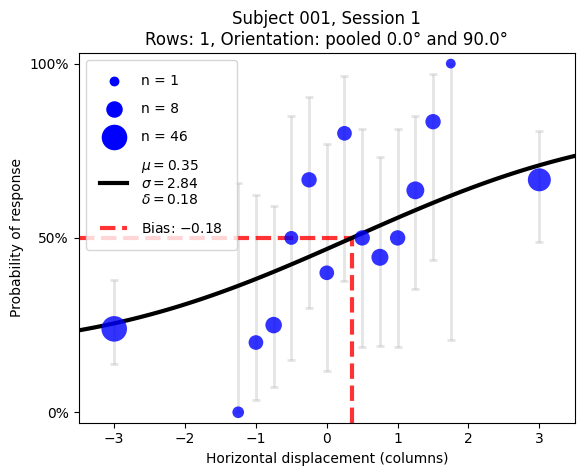

150
[-2.77555756e-17] []
Clipping to zero.


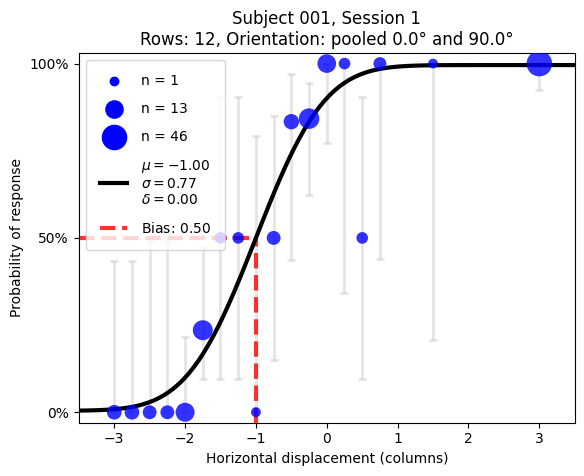

170


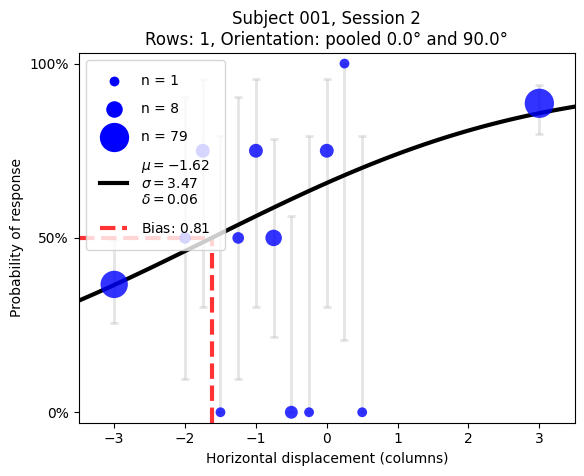

170


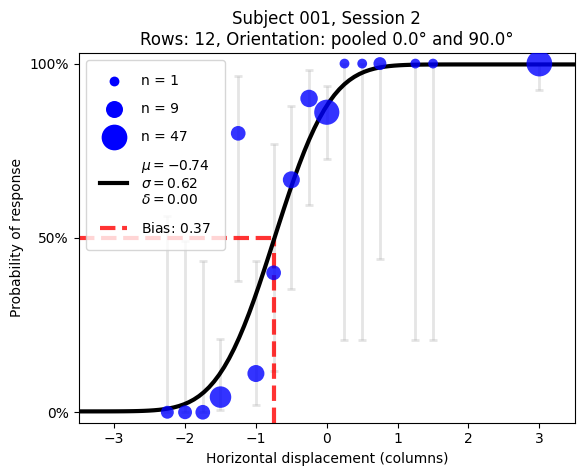

151


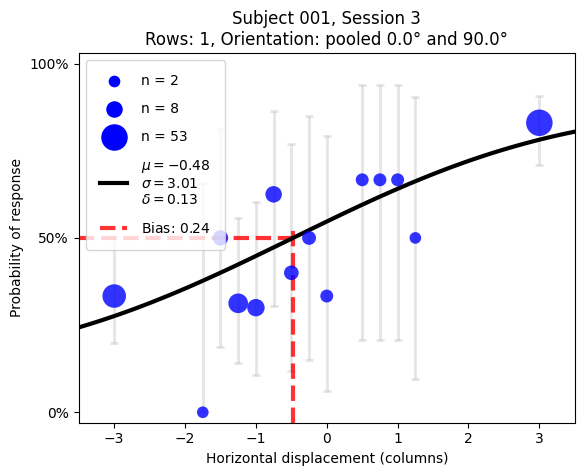

151


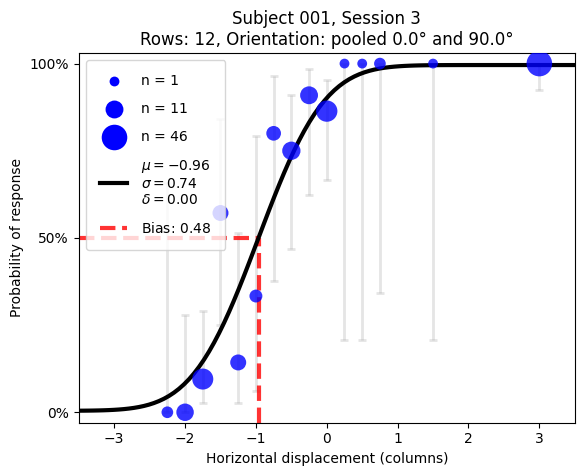

183


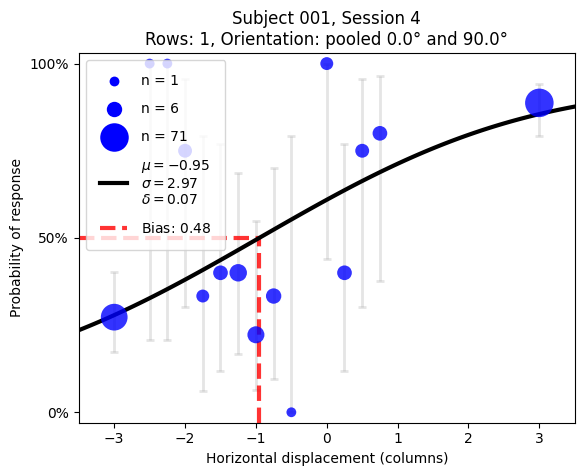

184


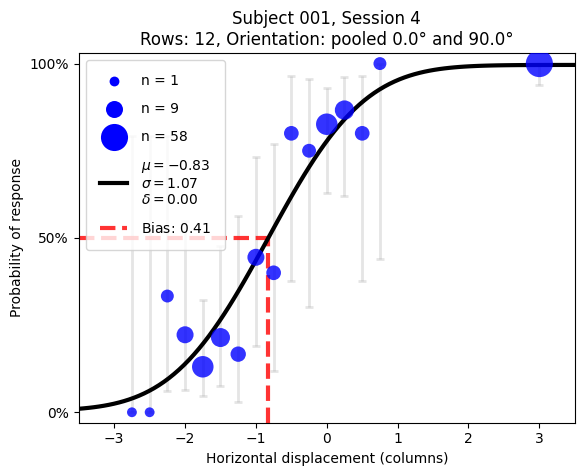

162


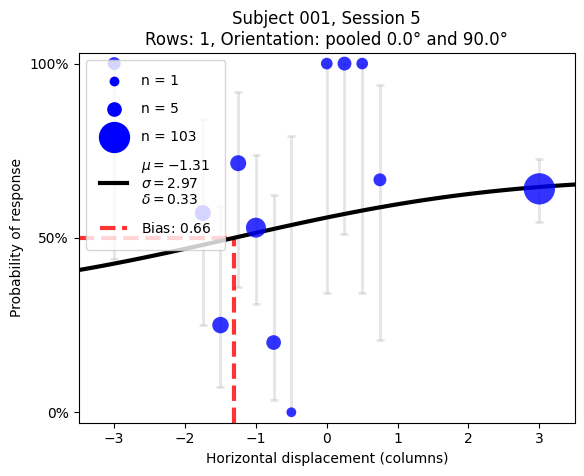

161


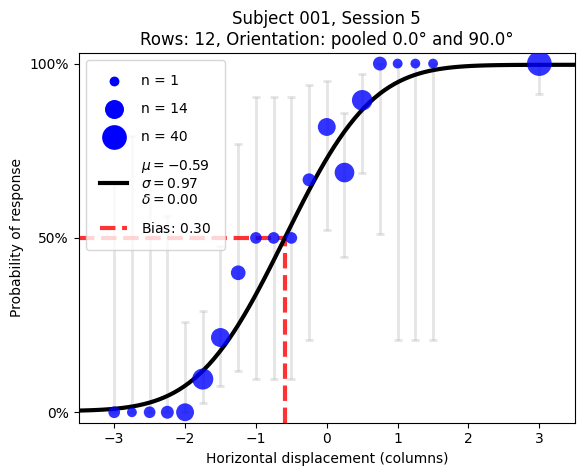

175


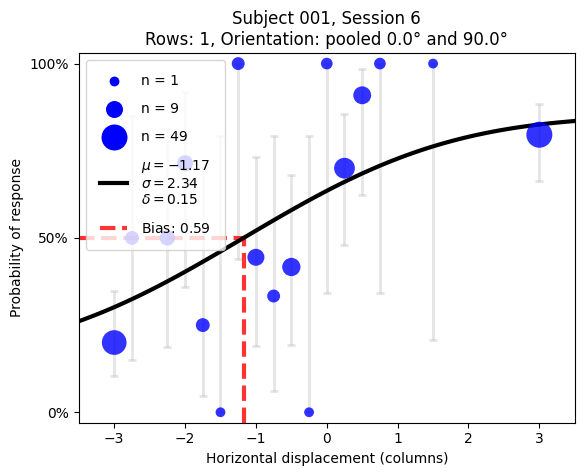

175
[] [-1.11022302e-16]
Clipping to zero.


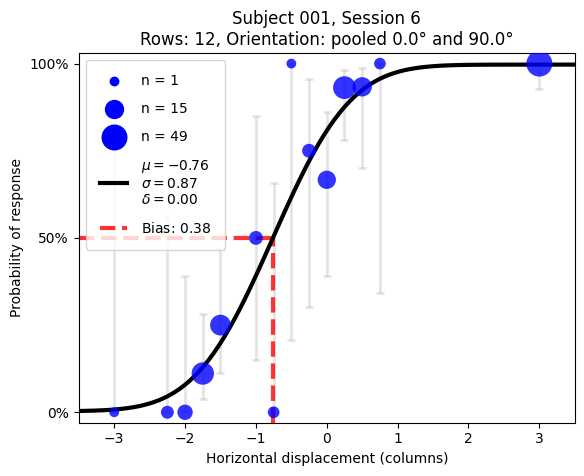

200


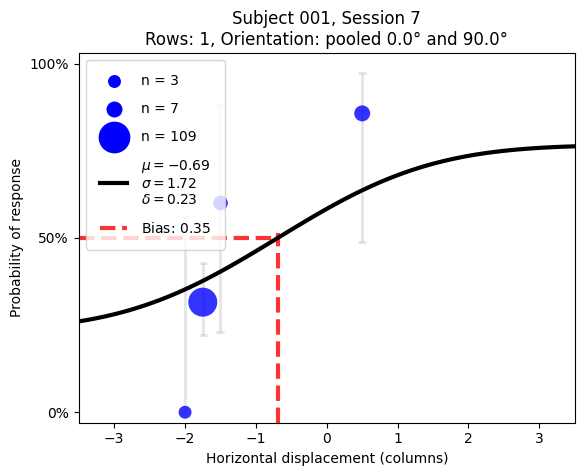

199


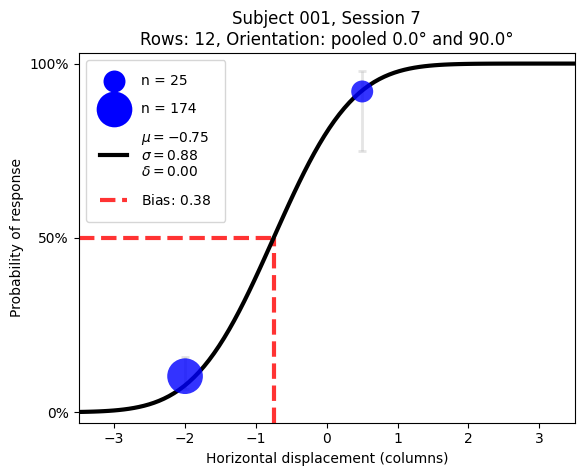

220


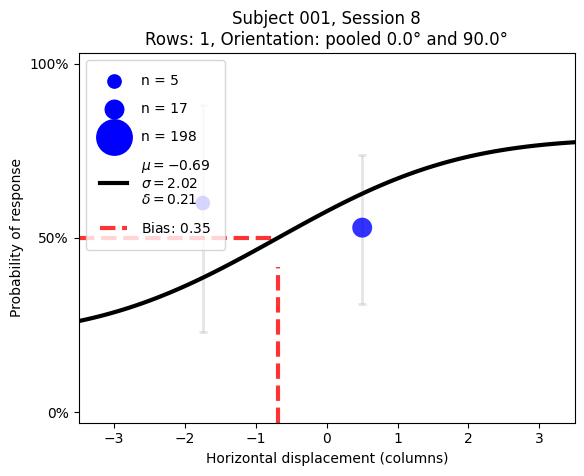

222


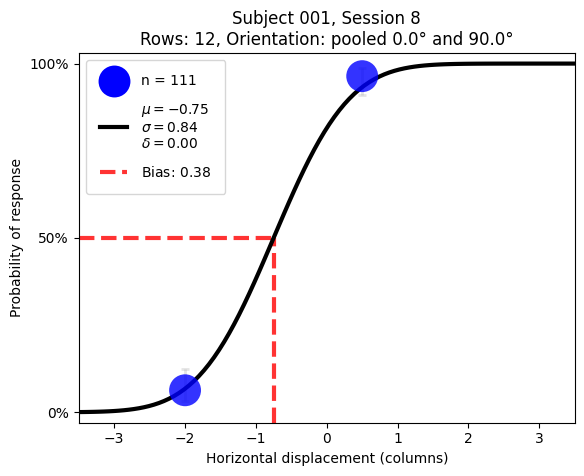

In [12]:
# TODO: put all of this into functions

size_scale = 50
results = {} # keys: n_rows, values: dict with keys 'biases' and 'orientations'
pooled_data = {"n_row": [], "displacement_cols": [], "response": []}

for session_id, session_df in data.items():
    # get test data only
    test_data = session_df[session_df['state'] == 'test']
    displacement = test_data['displacement_cols'].values
    choices = test_data['GetResponse.keys'].values
    orientation = test_data['orientation_degrees'].values
    session = test_data['session'].values
    n_rows = test_data['n_row'].values
    
    # find and remove NaNs transperently, e.g. due to aborted session for the last trial
    nan_mask = pd.isna(displacement) | pd.isna(choices) | pd.isna(orientation) | pd.isna(session) | pd.isna(n_rows)
    if np.sum(nan_mask) > 0:
        print("Warning: Removing", np.sum(nan_mask), "trials with NaN values")
        
        print("# of rows values:", n_rows)
        print("Displacement values:", displacement)
        print("Choices:", choices)
        print("Orientation values:", orientation)
        print("Session values:", session)
        
        displacement = displacement[~nan_mask]
        choices = choices[~nan_mask]
        orientation = orientation[~nan_mask]
        session = session[~nan_mask]
        n_rows = n_rows[~nan_mask]
    
    # extract unique orientation and session number
    assert np.all(session == session[0]), "All session numbers in a session should be the same"
    session = session[0]
    
    # compute probability of right choice for each displacement 
    unique_n_rows = np.unique(n_rows)
    for n_row in unique_n_rows:
        n_to_print = 0
        unique_orientation = np.unique(orientation % 90)  # ensure orientations are within [0, 90)
        for o in unique_orientation:
            if n_row not in results:
                results[n_row] = {'bias': [], 'sensitivity': [], 'orientation': [], 'lapse_rate': [], 'mean': [], 'std': []}
            
            mask = (n_rows == n_row) & (orientation % 90 == o)
            orientation_n = orientation[mask]
            choices_n = choices[mask]
            displacement_n = displacement[mask]
            
            unique_abs_disp_n = np.unique(np.abs(displacement_n))
            unique_abs_disp_n = unique_abs_disp_n[unique_abs_disp_n > 0]
            unique_disp_n = np.sort(np.concatenate((-unique_abs_disp_n, [0], unique_abs_disp_n)))
        
            probs = []
            cis_low, cis_up = [], []
            disp_selected = []
            n_data_points = []
            for disp in unique_disp_n:
                # for orientation == 0, upper right texture vertical -> positive displacement means upper texture more right
                # for orientation == 90, upper right texture horizontal -> positive displacement means upper texture more left
                responses_right = choices_n[(displacement_n == disp) & (orientation_n == o)] == "right"
                responses_left = choices_n[(displacement_n == -disp) & (orientation_n == (o + 90) % 180)] == "left"
                responses = np.concatenate([responses_right, responses_left])
                
                n = len(responses)
                if n == 0:
                    continue
                else:
                    k = np.sum(responses)
                    p = k / n 
                    probs.append(p)
                    
                    ci_low, ci_upp = proportion_confint(count=k, nobs=n, method='wilson')
                    cis_low.append(ci_low)
                    cis_up.append(ci_upp)
                    disp_selected.append(disp)
                    n_data_points.append(n)
                    
                    pooled_data["n_row"] += [n_row] * n
                    pooled_data["displacement_cols"] += [disp] * n
                    pooled_data["response"] += responses.tolist()
                    n_to_print += n
                    
            probs = np.array(probs)
            cis_low = np.array(cis_low)
            cis_up = np.array(cis_up)
            n_data_points = np.array(n_data_points)
            
            # Psi fit results
            mu, sigma, lapse_rate = qp_results[session_id][f'n_row={int(n_row)}_orientation_degrees={int(o % 90)}']
            bias = - 1/2 * mu 
            sensitivity = 1 / sigma
            
            results[n_row]['orientation'].append(o)
            results[n_row]['mean'].append(mu)
            results[n_row]['std'].append(sigma)
            results[n_row]['lapse_rate'].append(lapse_rate)
            results[n_row]['bias'].append(bias)
            results[n_row]['sensitivity'].append(sensitivity)
            
            print(n_to_print)
            
            # plot the data and fit
            psychometric_plot(
                title = f'Subject {subject_id}, Session {session}\nRows: {int(n_row)}, Orientation: pooled {o}° and {o + 90}°',
                probs = probs,
                probs_err_lower = (probs - cis_low),
                probs_err_upper =  (cis_up - probs),
                disp_selected = disp_selected,
                n_data_points = n_data_points,
                size_scale = size_scale,
                mu = mu,
                sigma = sigma,
                lapse_rate = lapse_rate
            )

# 3. Pool Sessions via ML + Bootstrapping

In [13]:
n_bootstrap = 10000
np.random.seed(42)

In [14]:
n_rows = np.array(pooled_data["n_row"])
displacement_cols = np.array(pooled_data["displacement_cols"])
responses = np.array(pooled_data["response"])

ML_results = {}
def neg_log_likelihood(params, displacement, responses):
    mu, sigma, lapse_rate = params
    # prevent invalid values
    if sigma <= 0 or lapse_rate < 0 or lapse_rate > 0.5:
        return np.inf
    probs = cumulative_gaussian(displacement, mu, sigma, lapse_rate)
    # prevent log(0)
    probs = np.clip(probs, 1e-6, 1 - 1e-6)
    log_likelihood = np.sum(responses * np.log(probs) + (1 - responses) * np.log(1 - probs))
    return -log_likelihood

for n_row in np.unique(n_rows):
    ML_results[n_row] = {}

    responses_n = responses[n_rows == n_row]
    displacement_n = displacement_cols[n_rows == n_row]
    n_trials = len(responses_n)
    
    # Total Maximum Likelihood Estimation
    initial_mean = np.array(results[n_row]['mean']).mean() # mean of means
    initial_std = np.sqrt(np.mean(np.array(results[n_row]['std'])**2)) # pooled std
    initial_lapse_rate = np.array(results[n_row]['lapse_rate']).mean() # mean of lapse rates
    initial_guess = [initial_mean, initial_std, initial_lapse_rate]
    
    ml_result = minimize(neg_log_likelihood, initial_guess, 
                    args=(displacement_n, responses_n),
                    bounds=[(None, None), (1e-6, None), (0, 0.5)],
                    method='L-BFGS-B')
    mu_mle, sigma_mle, lapse_rate_mle = ml_result.x
    
    min_ll = -neg_log_likelihood(ml_result.x, displacement_n, responses_n)
    BIC_value = BIC(n_trials, 3, min_ll)
    AIC_value = AIC(3, min_ll)
    
    print(f"MLE for {int(n_row)} rows:")
    print("================\n")
    print(f"    {ml_result.nit} iterations, optimization success: {ml_result.success}\n")
    print(f"    Initial guess: μ = {initial_mean:.3f}, σ = {initial_std:.3f}, δ = {initial_lapse_rate:.3f}\n")
    print(f"    BIC: {BIC_value:.3f}, AIC: {AIC_value:.3f}\n")
    print(f"    N = {n_trials}")
    
    # Bootstrapping
    bootstrap_params = []
    for _ in tqdm(range(n_bootstrap), "    -> Bootstrapping..", leave=True):
        # Resample trials with replacement
        boot_indices = np.random.choice(n_trials, size=n_trials, replace=True)
        boot_responses = responses_n[boot_indices]
        boot_displacement = displacement_n[boot_indices]
        
        # Fit to bootstrap sample
        result_boot = minimize(neg_log_likelihood, [mu_mle, sigma_mle, lapse_rate_mle],
                            args=(boot_displacement, boot_responses),
                            bounds=[(None, None), (1e-6, None), (0, 0.5)],
                            method='L-BFGS-B')
        
        if result_boot.success:
            bootstrap_params.append(result_boot.x)

    bootstrap_params = np.array(bootstrap_params)

    # Bootstrap confidence intervals (95%)
    mu_ci = np.percentile(bootstrap_params[:, 0], [2.5, 97.5])
    sigma_ci = np.percentile(bootstrap_params[:, 1], [2.5, 97.5])
    lapse_rate_ci = np.percentile(bootstrap_params[:, 2], [2.5, 97.5])

    # Save results
    ML_results[n_row]['mean'] = [mu_ci[0], mu_mle, mu_ci[1]]
    ML_results[n_row]['std'] = [sigma_ci[0], sigma_mle, sigma_ci[1]]
    ML_results[n_row]['lapse_rate'] = [lapse_rate_ci[0], lapse_rate_mle, lapse_rate_ci[1]]
    ML_results[n_row]["bootstrap_params"] = bootstrap_params 
    ML_results[n_row]["BIC"] = BIC_value
    ML_results[n_row]["AIC"] = AIC_value
    
    print(f"\n    MLE estimates:")
    print(f"        μ = {mu_mle:.3f} [{mu_ci[0]:.3f}, {mu_ci[1]:.3f}]")
    print(f"        σ = {sigma_mle:.3f} [{sigma_ci[0]:.3f}, {sigma_ci[1]:.3f}]")
    print(f"        δ = {lapse_rate_mle:.3f} [{lapse_rate_ci[0]:.3f}, {lapse_rate_ci[1]:.3f}]")
    print("\n")   

MLE for 1 rows:

    13 iterations, optimization success: True

    Initial guess: μ = -0.821, σ = 2.723, δ = 0.170

    BIC: 1691.416, AIC: 1675.659

    N = 1411


    -> Bootstrapping..: 100%|██████████| 10000/10000 [01:37<00:00, 102.93it/s]



    MLE estimates:
        μ = -0.711 [-1.101, -0.309]
        σ = 1.839 [0.986, 2.645]
        δ = 0.222 [0.178, 0.262]


MLE for 12 rows:

    5 iterations, optimization success: True

    Initial guess: μ = -0.797, σ = 0.853, δ = 0.003

    BIC: 818.850, AIC: 803.092

    N = 1412


    -> Bootstrapping..: 100%|██████████| 10000/10000 [01:09<00:00, 143.06it/s]


    MLE estimates:
        μ = -0.831 [-0.913, -0.750]
        σ = 0.827 [0.758, 0.900]
        δ = 0.000 [0.000, 0.000]




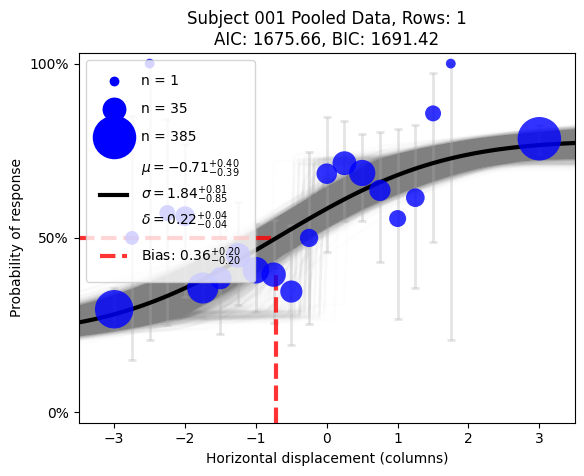

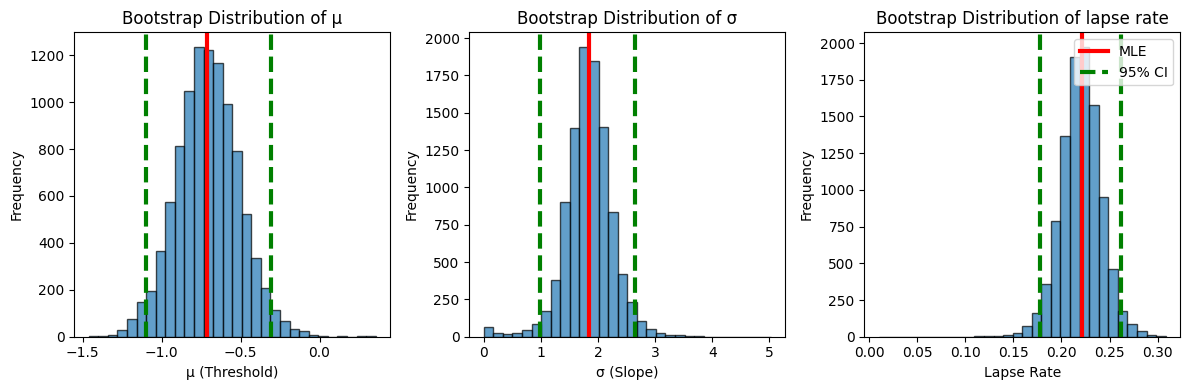

[-2.77555756e-17 -2.77555756e-17] []
Clipping to zero.


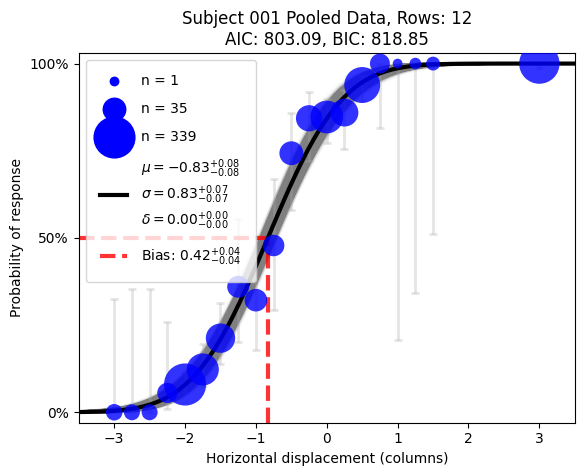

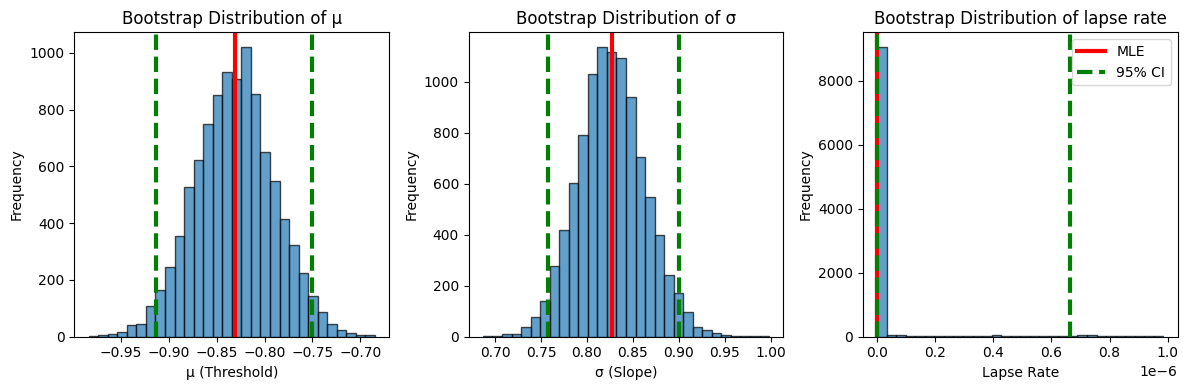

In [15]:
n_rows = np.array(pooled_data["n_row"])
displacement_cols = np.array(pooled_data["displacement_cols"])
responses = np.array(pooled_data["response"])

for n_row in ML_results.keys():
    mean_ci = ML_results[n_row]['mean']
    std_ci = ML_results[n_row]['std']   
    lapse_rate_ci = ML_results[n_row]['lapse_rate']
    bootstrap_params = ML_results[n_row]["bootstrap_params"]
    BIC_value = ML_results[n_row]["BIC"]
    AIC_value = ML_results[n_row]["AIC"]
    
    # Visualization
    responses_n = responses[n_rows == n_row]
    displacement_n = displacement_cols[n_rows == n_row]
    
    probs = []
    cis_low, cis_up = [], []
    disp_selected = []
    n_data_points = []
    for disp in np.unique(displacement_n):
        n = np.sum(displacement_n == disp)
        if n == 0:
            continue
        else:
            k = np.sum(responses_n[displacement_n == disp])
            p = k / n 
            probs.append(p)
            
            ci_low, ci_upp = proportion_confint(count=k, nobs=n, method='wilson')
            
            cis_low.append(ci_low)
            cis_up.append(ci_upp)
            disp_selected.append(disp)
            n_data_points.append(n)
    
    probs = np.array(probs)
    cis_low = np.array(cis_low)
    cis_up = np.array(cis_up)
    n_data_points = np.array(n_data_points)
    
    psychometric_plot(
        title = f'Subject {subject_id} Pooled Data, Rows: {int(n_row)}\nAIC: {AIC_value:.2f}, BIC: {BIC_value:.2f}',
        probs = probs,
        probs_err_lower = (probs - cis_low),
        probs_err_upper =  (cis_up - probs),
        disp_selected = disp_selected,
        n_data_points = n_data_points,
        size_scale = size_scale,
        mu = mean_ci,
        sigma = std_ci,
        lapse_rate = lapse_rate_ci,
        bootstrap_params = bootstrap_params,
        verbose = True 
    )

    # Bootstrap distribution plots
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].hist(bootstrap_params[:, 0], bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(mean_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[0].axvline(mean_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[0].axvline(mean_ci[2], color='g', linestyle='--', linewidth=3)
    axes[0].set_xlabel('μ (Threshold)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Bootstrap Distribution of μ')

    axes[1].hist(bootstrap_params[:, 1], bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(std_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[1].axvline(std_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[1].axvline(std_ci[2], color='g', linestyle='--', linewidth=3)
    axes[1].set_xlabel('σ (Slope)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Bootstrap Distribution of σ')
    
    axes[2].hist(bootstrap_params[:, 2], bins=30, edgecolor='black', alpha=0.7)
    axes[2].axvline(lapse_rate_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[2].axvline(lapse_rate_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[2].axvline(lapse_rate_ci[2], color='g', linestyle='--', linewidth=3)
    axes[2].set_xlabel('Lapse Rate')
    axes[2].set_ylabel('Frequency')
    axes[2].legend(loc = "upper right")
    axes[2].set_title('Bootstrap Distribution of lapse rate')

    plt.tight_layout()
    plt.show()

In [16]:
n_rows = np.array(pooled_data["n_row"])
displacement_cols = np.array(pooled_data["displacement_cols"])
responses = np.array(pooled_data["response"])

ML_results_2 = {}
def neg_log_likelihood_2(params, displacement, responses):
    mu, sigma, lapse_rate_left, lapse_rate_right = params
    # prevent invalid values
    if sigma <= 0 or lapse_rate_left < 0 or lapse_rate_left > 0.5 or lapse_rate_right < 0 or lapse_rate_right > 0.5:
        return np.inf
    probs = cumulative_gaussian_2(displacement, mu, sigma, lapse_rate_left, lapse_rate_right)
    # prevent log(0)
    probs = np.clip(probs, 1e-6, 1 - 1e-6)
    log_likelihood = np.sum(responses * np.log(probs) + (1 - responses) * np.log(1 - probs))
    return -log_likelihood

for n_row in np.unique(n_rows):
    ML_results_2[n_row] = {}

    responses_n = responses[n_rows == n_row]
    displacement_n = displacement_cols[n_rows == n_row]
    n_trials = len(responses_n)
    
    # Total Maximum Likelihood Estimation
    initial_mean = np.array(results[n_row]['mean']).mean() # mean of means
    initial_std = np.sqrt(np.mean(np.array(results[n_row]['std'])**2)) # pooled std
    initial_lapse_rate_left = np.array(results[n_row]['lapse_rate']).mean() # mean of lapse rates for left
    initial_lapse_rate_right = np.array(results[n_row]['lapse_rate']).mean()  # mean of lapse rates for right
    initial_guess = [initial_mean, initial_std, initial_lapse_rate_left, initial_lapse_rate_right]
    
    ml_result = minimize(neg_log_likelihood_2, initial_guess, 
                    args=(displacement_n, responses_n),
                    bounds=[(None, None), (1e-6, None), (0, 0.5), (0, 0.5)],
                    method='L-BFGS-B')
    mu_mle, sigma_mle, lapse_rate_left_mle, lapse_rate_right_mle = ml_result.x
    
    min_ll = -neg_log_likelihood_2(ml_result.x, displacement_n, responses_n)
    BIC_value = BIC(n_trials, 4, min_ll)
    AIC_value = AIC(4, min_ll)
    
    print(f"MLE for {int(n_row)} rows:")
    print("================\n")
    print(f"    {ml_result.nit} iterations, optimization success: {ml_result.success}\n")
    print(f"    Initial guess: μ = {initial_mean:.3f}, σ = {initial_std:.3f}, δ_left = {initial_lapse_rate_left:.3f}, δ_right = {initial_lapse_rate_right:.3f}\n")
    print(f"    BIC: {BIC_value:.3f}, AIC: {AIC_value:.3f}\n")
    print(f"    N = {n_trials}")
    
    # Bootstrapping
    bootstrap_params = []
    for _ in tqdm(range(n_bootstrap), "    -> Bootstrapping..", leave=True):
        # Resample trials with replacement
        boot_indices = np.random.choice(n_trials, size=n_trials, replace=True)
        boot_responses = responses_n[boot_indices]
        boot_displacement = displacement_n[boot_indices]
        
        # Fit to bootstrap sample
        result_boot = minimize(neg_log_likelihood_2, [mu_mle, sigma_mle, lapse_rate_left_mle, lapse_rate_right_mle],
                            args=(boot_displacement, boot_responses),
                            bounds=[(None, None), (1e-6, None), (0, 0.5), (0, 0.5)],
                            method='L-BFGS-B')
        
        if result_boot.success:
            bootstrap_params.append(result_boot.x)

    bootstrap_params = np.array(bootstrap_params)

    # Bootstrap confidence intervals (95%)
    mu_ci = np.percentile(bootstrap_params[:, 0], [2.5, 97.5])
    sigma_ci = np.percentile(bootstrap_params[:, 1], [2.5, 97.5])
    lapse_rate_left_ci = np.percentile(bootstrap_params[:, 2], [2.5, 97.5])
    lapse_rate_right_ci = np.percentile(bootstrap_params[:, 3], [2.5, 97.5])

    # Save results
    ML_results_2[n_row]['mean'] = [mu_ci[0], mu_mle, mu_ci[1]]
    ML_results_2[n_row]['std'] = [sigma_ci[0], sigma_mle, sigma_ci[1]]
    ML_results_2[n_row]['lapse_rate_left'] = [lapse_rate_left_ci[0], lapse_rate_left_mle, lapse_rate_left_ci[1]]
    ML_results_2[n_row]['lapse_rate_right'] = [lapse_rate_right_ci[0], lapse_rate_right_mle, lapse_rate_right_ci[1]]
    ML_results_2[n_row]["bootstrap_params"] = bootstrap_params 
    ML_results_2[n_row]["BIC"] = BIC_value
    ML_results_2[n_row]["AIC"] = AIC_value
    
    print(f"\n    MLE estimates:")
    print(f"        μ = {mu_mle:.3f} [{mu_ci[0]:.3f}, {mu_ci[1]:.3f}]")
    print(f"        σ = {sigma_mle:.3f} [{sigma_ci[0]:.3f}, {sigma_ci[1]:.3f}]")
    print(f"        δ_left = {lapse_rate_left_mle:.3f} [{lapse_rate_left_ci[0]:.3f}, {lapse_rate_left_ci[1]:.3f}]")
    print(f"        δ_right = {lapse_rate_right_mle:.3f} [{lapse_rate_right_ci[0]:.3f}, {lapse_rate_right_ci[1]:.3f}]")
    print("\n")   

MLE for 1 rows:

    18 iterations, optimization success: True

    Initial guess: μ = -0.821, σ = 2.723, δ_left = 0.170, δ_right = 0.170

    BIC: 1696.358, AIC: 1675.350

    N = 1411


    -> Bootstrapping..: 100%|██████████| 10000/10000 [02:37<00:00, 63.66it/s]



    MLE estimates:
        μ = -0.228 [-1.225, 0.251]
        σ = 1.172 [0.000, 2.382]
        δ_left = 0.312 [0.133, 0.380]
        δ_right = 0.223 [0.187, 0.258]


MLE for 12 rows:

    6 iterations, optimization success: True

    Initial guess: μ = -0.797, σ = 0.853, δ_left = 0.003, δ_right = 0.003

    BIC: 826.103, AIC: 805.092

    N = 1412


    -> Bootstrapping..: 100%|██████████| 10000/10000 [01:52<00:00, 89.07it/s]


    MLE estimates:
        μ = -0.831 [-0.910, -0.710]
        σ = 0.827 [0.723, 0.897]
        δ_left = 0.000 [0.000, 0.043]
        δ_right = 0.000 [0.000, 0.000]




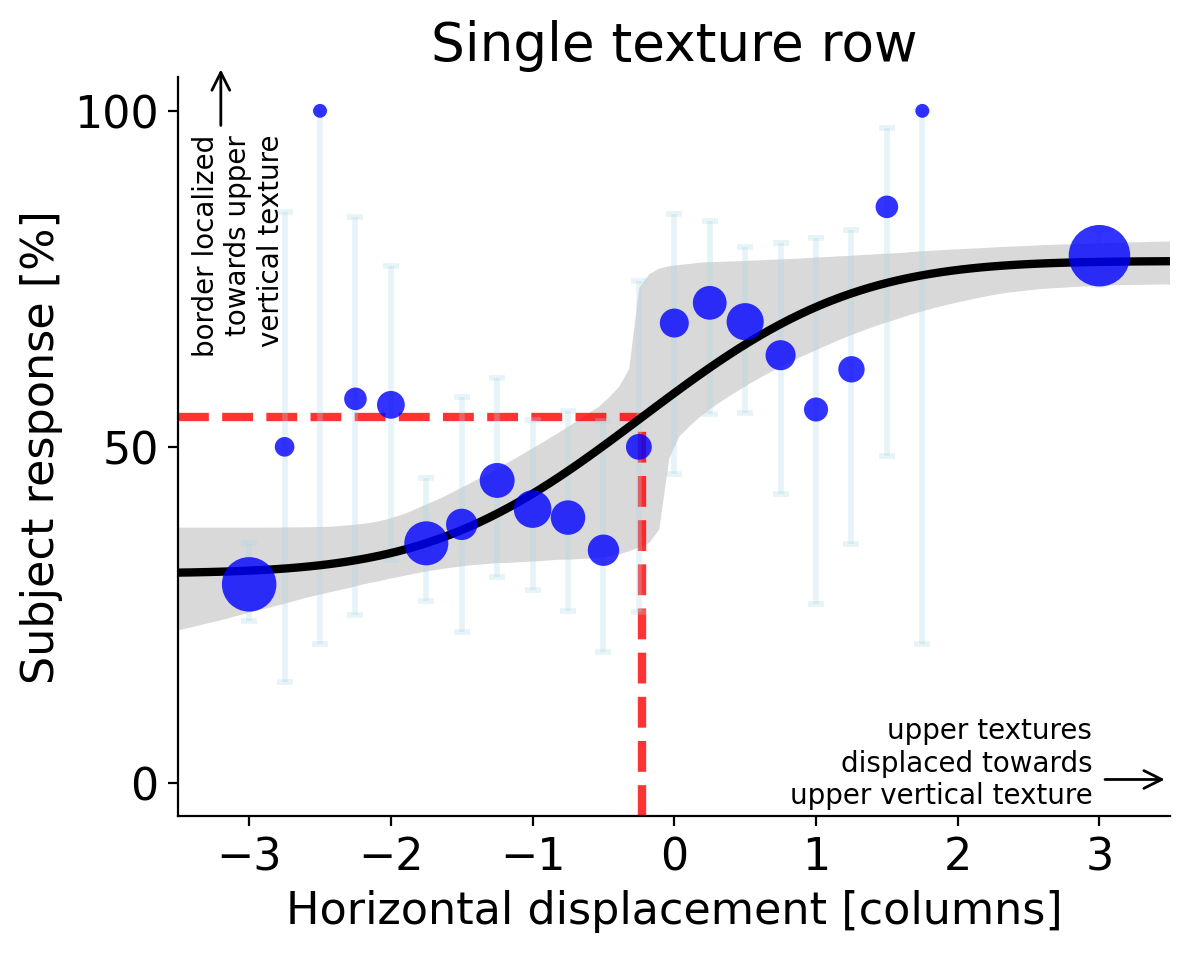

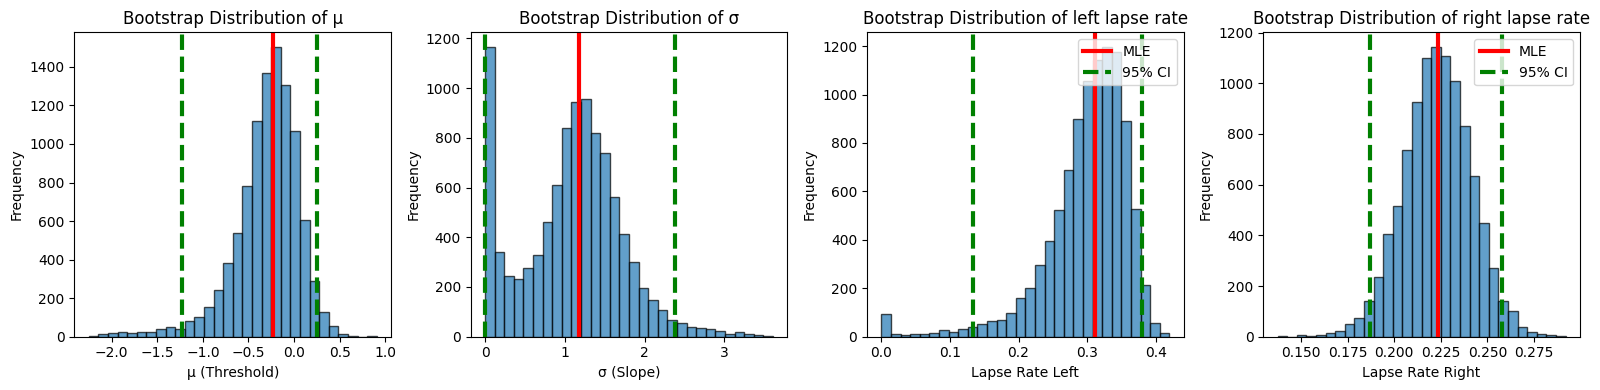

[-2.77555756e-17 -2.77555756e-17] []
Clipping to zero.


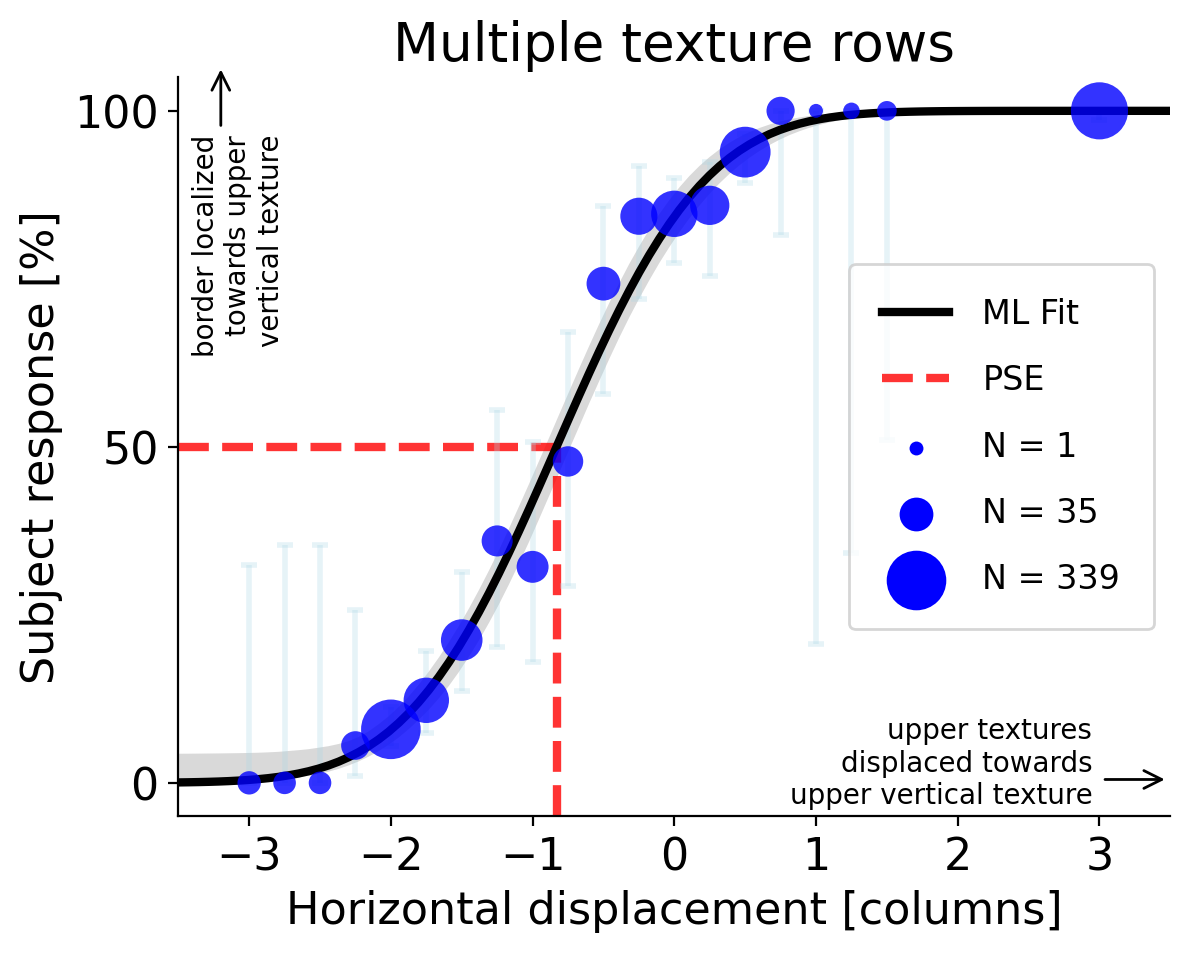

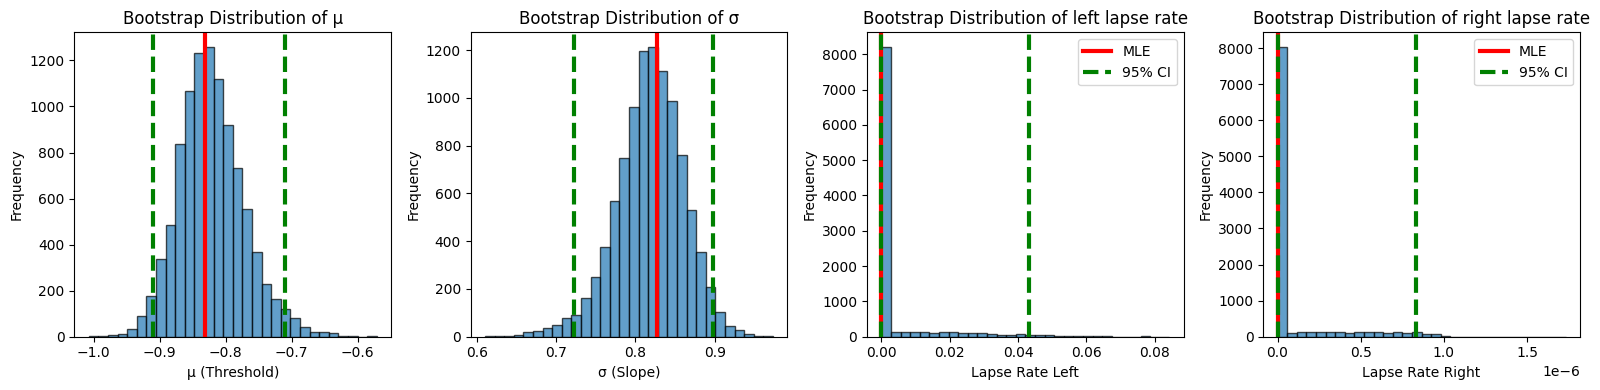

In [317]:
n_rows = np.array(pooled_data["n_row"])
displacement_cols = np.array(pooled_data["displacement_cols"])
responses = np.array(pooled_data["response"])

for n_row in ML_results_2.keys():
    mean_ci = ML_results_2[n_row]['mean']
    std_ci = ML_results_2[n_row]['std']   
    lapse_rate_left_ci = ML_results_2[n_row]['lapse_rate_left']
    lapse_rate_right_ci = ML_results_2[n_row]['lapse_rate_right']
    bootstrap_params = ML_results_2[n_row]["bootstrap_params"]
    BIC_value = ML_results_2[n_row]["BIC"]
    AIC_value = ML_results_2[n_row]["AIC"]
    
    # Visualization
    responses_n = responses[n_rows == n_row]
    displacement_n = displacement_cols[n_rows == n_row]
    
    probs = []
    cis_low, cis_up = [], []
    disp_selected = []
    n_data_points = []
    for disp in np.unique(displacement_n):
        n = np.sum(displacement_n == disp)
        if n == 0:
            continue
        else:
            k = np.sum(responses_n[displacement_n == disp])
            p = k / n 
            probs.append(p)
            
            ci_low, ci_upp = proportion_confint(count=k, nobs=n, method='wilson')
            
            cis_low.append(ci_low)
            cis_up.append(ci_upp)
            disp_selected.append(disp)
            n_data_points.append(n)
    
    probs = np.array(probs)
    cis_low = np.array(cis_low)
    cis_up = np.array(cis_up)
    n_data_points = np.array(n_data_points)
    
    # psychometric_plot(
    #     title = f'Subject {subject_id} Pooled Data, Rows: {int(n_row)}\nAIC: {AIC_value:.2f}, BIC: {BIC_value:.2f}',
    #     probs = probs,
    #     probs_err_lower = (probs - cis_low),
    #     probs_err_upper =  (cis_up - probs),
    #     disp_selected = disp_selected,
    #     n_data_points = n_data_points,
    #     size_scale = size_scale,
    #     mu = mean_ci,
    #     sigma = std_ci,
    #     lapse_rate = lapse_rate_left_ci,
    #     lapse_rate_right = lapse_rate_right_ci,
    #     bootstrap_params = bootstrap_params,
    #     verbose = True 
    # )
    
    psychometric_plot_2(
        title = 'Single texture row' if n_row == 1 else "Multiple texture rows",
        probs = probs,
        probs_err_lower = (probs - cis_low),
        probs_err_upper =  (cis_up - probs),
        disp_selected = disp_selected,
        n_data_points = n_data_points,
        size_scale = 25,
        mu = mean_ci,
        sigma = std_ci,
        lapse_rate = lapse_rate_left_ci,
        lapse_rate_right = lapse_rate_right_ci,
        bootstrap_params = bootstrap_params,
        verbose = True,
        dpi = 200,
        show_legend = n_row != 1
    )

    # Bootstrap distribution plots
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes[0].hist(bootstrap_params[:, 0], bins=30, edgecolor='black', alpha=0.7)
    axes[0].axvline(mean_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[0].axvline(mean_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[0].axvline(mean_ci[2], color='g', linestyle='--', linewidth=3)
    axes[0].set_xlabel('μ (Threshold)')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Bootstrap Distribution of μ')

    axes[1].hist(bootstrap_params[:, 1], bins=30, edgecolor='black', alpha=0.7)
    axes[1].axvline(std_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[1].axvline(std_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[1].axvline(std_ci[2], color='g', linestyle='--', linewidth=3)
    axes[1].set_xlabel('σ (Slope)')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Bootstrap Distribution of σ')
    
    axes[2].hist(bootstrap_params[:, 2], bins=30, edgecolor='black', alpha=0.7)
    axes[2].axvline(lapse_rate_left_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[2].axvline(lapse_rate_left_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[2].axvline(lapse_rate_left_ci[2], color='g', linestyle='--', linewidth=3)
    axes[2].set_xlabel('Lapse Rate Left')
    axes[2].set_ylabel('Frequency')
    axes[2].legend(loc = "upper right")
    axes[2].set_title('Bootstrap Distribution of left lapse rate')
    
    axes[3].hist(bootstrap_params[:, 3], bins=30, edgecolor='black', alpha=0.7)
    axes[3].axvline(lapse_rate_right_ci[1], color='r', linestyle='-', label='MLE', linewidth=3)
    axes[3].axvline(lapse_rate_right_ci[0], color='g', linestyle='--', label='95% CI', linewidth=3)
    axes[3].axvline(lapse_rate_right_ci[2], color='g', linestyle='--', linewidth=3)
    axes[3].set_xlabel('Lapse Rate Right')
    axes[3].set_ylabel('Frequency')
    axes[3].legend(loc = "upper right")
    axes[3].set_title('Bootstrap Distribution of right lapse rate')

    plt.tight_layout()
    plt.show()

# 4. Permutation Hypothesis Tests

In [18]:
n_permutations = 10000
np.random.seed(44)

In [19]:
def neg_log_likelihood(params, displacement, responses):
    mu, sigma, lapse_rate = params
    # prevent invalid values
    if sigma <= 0 or lapse_rate < 0 or lapse_rate > 0.5:
        return np.inf
    probs = cumulative_gaussian(displacement, mu, sigma, lapse_rate)
    # prevent log(0)
    probs = np.clip(probs, 1e-6, 1 - 1e-6)
    log_likelihood = np.sum(responses * np.log(probs) + (1 - responses) * np.log(1 - probs))
    return -log_likelihood

pooled_n_rows = np.array(pooled_data["n_row"])
pooled_displacement_cols = np.array(pooled_data["displacement_cols"])
pooled_responses = np.array(pooled_data["response"])
n_trials = len(responses_n)
print(f"N = {n_trials}")
    
# permutation test
biases = {n_row: [] for n_row in np.unique(pooled_n_rows)}
sigmas = {n_row: [] for n_row in np.unique(pooled_n_rows)}
lapse_rates = {n_row: [] for n_row in np.unique(pooled_n_rows)}

for _ in tqdm(range(n_permutations), "    -> Permutating..", leave=True):
    # Shuffle conditions
    reshuffled_n_rows = np.random.permutation(pooled_n_rows)
    
    biases_ = {}
    success_flags = {}
    for n_row in np.unique(pooled_n_rows): 
        responses_n = pooled_responses[reshuffled_n_rows == n_row]
        displacement_n = pooled_displacement_cols[reshuffled_n_rows == n_row]
        
        initial_mean = ML_results[n_row]['mean'][1]  # MLE mean
        initial_std = ML_results[n_row]['std'][1]  # MLE std
        initial_lapse_rate = ML_results[n_row]['lapse_rate'][1]  # MLE lapse rate
        
        result_perm = minimize(neg_log_likelihood, [initial_mean, initial_std, initial_lapse_rate],
                            args=(displacement_n, responses_n),
                            bounds=[(None, None), (1e-6, None), (0, 0.5)],
                            method='L-BFGS-B')
        
        mu, sigma, lapse_rate = result_perm.x
        bias = - 1/2 * mu
        biases_[n_row] = bias
        sigmas[n_row].append(sigma)
        lapse_rates[n_row].append(lapse_rate)
        
        success_flags[n_row] = result_perm.success
    
    # Save only if all fits succeeded
    if all(success_flags.values()):
        for n_row in np.unique(pooled_n_rows):
            biases[n_row].append(biases_[n_row])
            sigmas[n_row].append(sigma)
            lapse_rates[n_row].append(lapse_rate)

# Save permutation test results
PT_results = {}        
for n_row in np.unique(pooled_n_rows):
    PT_results[n_row] = {}
    PT_results[n_row]['bias'] = np.array(biases[n_row])
    PT_results[n_row]['std'] = np.array(sigmas[n_row])
    PT_results[n_row]['lapse_rate'] = np.array(lapse_rates[n_row])

N = 1412


    -> Permutating..: 100%|██████████| 10000/10000 [04:23<00:00, 38.02it/s]


Permutation Test Results:

Bias:
Observed difference between 12 rows and 1 row: 0.0603
P-value: 0.4312073806658644

Sensitivity (Sigma):
Observed difference between 12 rows and 1 row: 1.0117
P-value: 0.0007510514720608853

Lapse Rate:
Observed difference between 12 rows and 1 row: 0.2216
P-value: 0.0



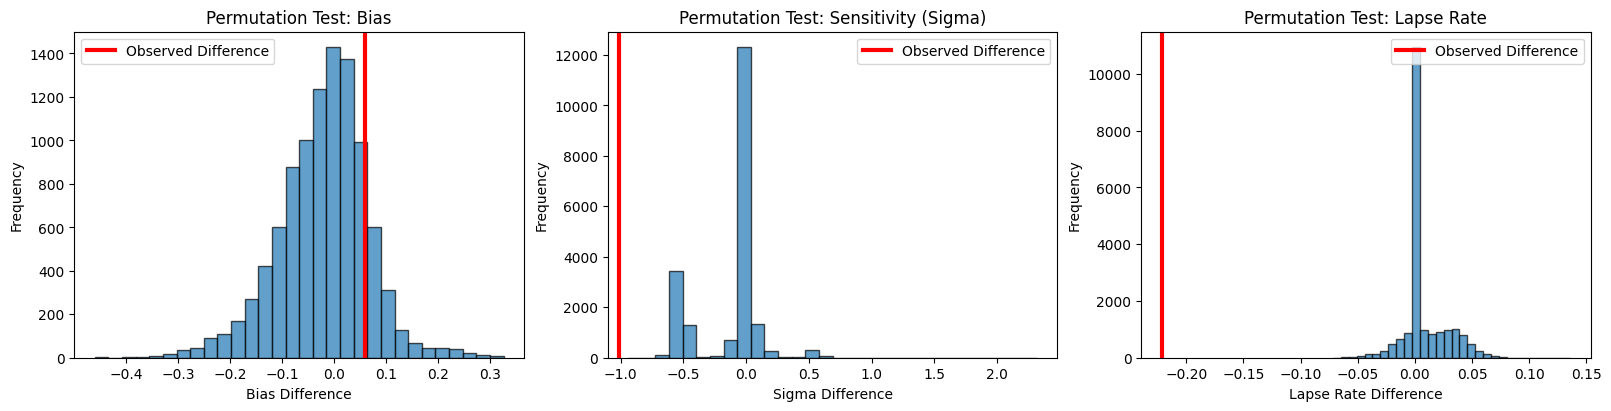

In [270]:
# Test results
print("Permutation Test Results:")
print("=========================\n")

# for biases: 
observed_bias_12 = - 0.5 * ML_results[12]['mean'][1]
observed_bias_1 = - 0.5 * ML_results[1]['mean'][1]
observed_difference = abs(observed_bias_12 - observed_bias_1)
p_value = np.mean(np.abs(PT_results[12]['bias'] - PT_results[1]['bias']) >= observed_difference)
print("Bias:")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")

# for sigmas:
observed_sigma_12 = ML_results[12]['std'][1]
observed_sigma_1 = ML_results[1]['std'][1]
observed_difference = abs(observed_sigma_12 - observed_sigma_1)
p_value = np.mean(np.abs(PT_results[12]['std'] - PT_results[1]['std']) >= observed_difference)
print("Sensitivity (Sigma):")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")

# for lapse rates:
observed_lapse_rate_12 = ML_results[12]['lapse_rate'][1]
observed_lapse_rate_1 = ML_results[1]['lapse_rate'][1]
observed_difference = abs(observed_lapse_rate_12 - observed_lapse_rate_1)
p_value = np.mean(np.abs(PT_results[12]['lapse_rate'] - PT_results[1]['lapse_rate']) >= observed_difference)
print("Lapse Rate:")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")

# Visualize permutation test results using histograms
fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

# Bias
axes[0].hist(PT_results[12]['bias'] - PT_results[1]['bias'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(observed_bias_12 - observed_bias_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[0].set_xlabel('Bias Difference')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Permutation Test: Bias')
axes[0].legend()

# Sensitivity (Sigma)
axes[1].hist(PT_results[12]['std'] - PT_results[1]['std'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(observed_sigma_12 - observed_sigma_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[1].set_xlabel('Sigma Difference')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Permutation Test: Sensitivity (Sigma)')
axes[1].legend()

# Lapse Rate 
axes[2].hist(PT_results[12]['lapse_rate'] - PT_results[1]['lapse_rate'], bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(observed_lapse_rate_12 - observed_lapse_rate_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[2].set_xlabel('Lapse Rate Difference')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Permutation Test: Lapse Rate')
axes[2].legend()

plt.show()

In [21]:
pooled_n_rows = np.array(pooled_data["n_row"])
pooled_displacement_cols = np.array(pooled_data["displacement_cols"])
pooled_responses = np.array(pooled_data["response"])
n_trials = len(responses_n)
print(f"N = {n_trials}")
    
# permutation test
biases = {n_row: [] for n_row in np.unique(pooled_n_rows)}
sigmas = {n_row: [] for n_row in np.unique(pooled_n_rows)}
lapse_rates = {n_row: [] for n_row in np.unique(pooled_n_rows)}
lapse_rates_right = {n_row: [] for n_row in np.unique(pooled_n_rows)}

for _ in tqdm(range(n_permutations), "    -> Permutating..", leave=True):
    # Shuffle conditions
    reshuffled_n_rows = np.random.permutation(pooled_n_rows)
    
    biases_ = {}
    success_flags = {}
    for n_row in np.unique(pooled_n_rows): 
        responses_n = pooled_responses[reshuffled_n_rows == n_row]
        displacement_n = pooled_displacement_cols[reshuffled_n_rows == n_row]
        
        initial_mean = ML_results_2[n_row]['mean'][1]  # MLE mean
        initial_std = ML_results_2[n_row]['std'][1]  # MLE std
        initial_lapse_rate = ML_results_2[n_row]['lapse_rate_left'][1]  # MLE lapse rate
        initial_lapse_rate_right = ML_results_2[n_row]['lapse_rate_right'][1]  # MLE lapse rate right
        
        result_perm = minimize(neg_log_likelihood_2, [initial_mean, initial_std, initial_lapse_rate, initial_lapse_rate_right],
                            args=(displacement_n, responses_n),
                            bounds=[(None, None), (1e-6, None), (0, 0.5), (0, 0.5)],
                            method='L-BFGS-B')
        
        mu, sigma, lapse_rate, lapse_rate_right = result_perm.x
        bias = - 1/2 * mu
        biases_[n_row] = bias
        sigmas[n_row].append(sigma)
        lapse_rates[n_row].append(lapse_rate)
        lapse_rates_right[n_row].append(lapse_rate_right)
        
        success_flags[n_row] = result_perm.success
    
    # Save only if all fits succeeded
    if all(success_flags.values()):
        for n_row in np.unique(pooled_n_rows):
            biases[n_row].append(biases_[n_row])
            sigmas[n_row].append(sigma)
            lapse_rates[n_row].append(lapse_rate)
            lapse_rates_right[n_row].append(lapse_rate_right)

# Save permutation test results
PT_results_2 = {}        
for n_row in np.unique(pooled_n_rows):
    PT_results_2[n_row] = {}
    PT_results_2[n_row]['bias'] = np.array(biases[n_row])
    PT_results_2[n_row]['std'] = np.array(sigmas[n_row])
    PT_results_2[n_row]['lapse_rate_left'] = np.array(lapse_rates[n_row])
    PT_results_2[n_row]['lapse_rate_right'] = np.array(lapse_rates_right[n_row])

N = 1412


    -> Permutating..:   0%|          | 0/10000 [00:00<?, ?it/s]

    -> Permutating..: 100%|██████████| 10000/10000 [05:29<00:00, 30.32it/s]


Permutation Test Results:

Bias:
Observed difference between 12 rows and 1 row: 0.3016
P-value: 0.00030199315482182406

Sensitivity (Sigma):
Observed difference between 12 rows and 1 row: -0.3445
P-value: 0.2179191331393599

Lapse Rate (left):
Observed difference between 12 rows and 1 row: -0.3116
P-value: 0.0

Lapse Rate (right):
Observed difference between 12 rows and 1 row: -0.2234
P-value: 0.0



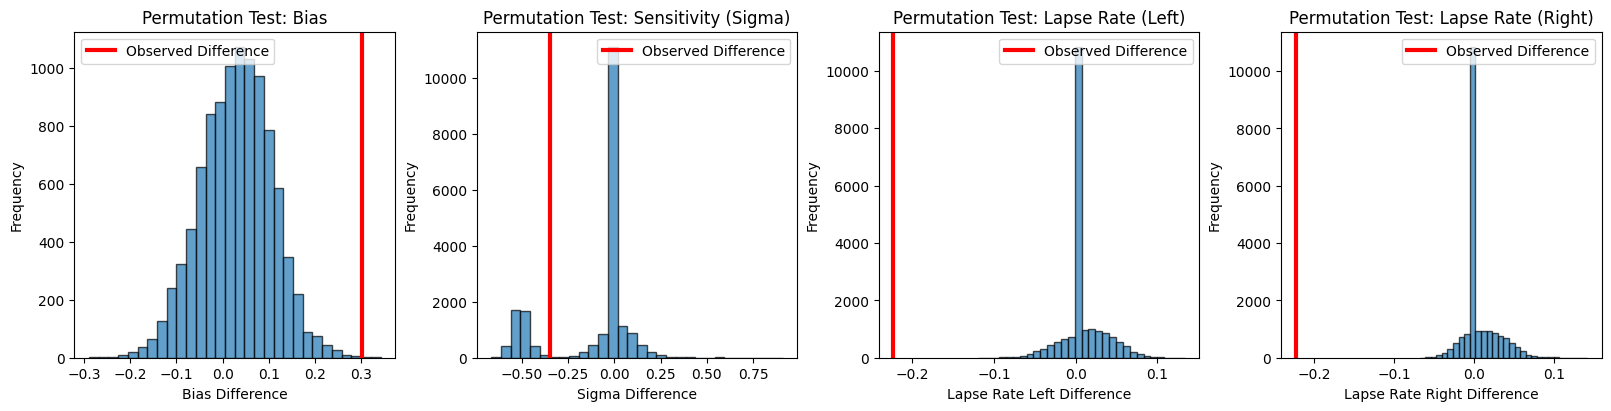

In [267]:
# Test results
print("Permutation Test Results:")
print("=========================\n")

# for biases: 
observed_bias_12 = - 0.5 * ML_results_2[12]['mean'][1]
observed_bias_1 = - 0.5 * ML_results_2[1]['mean'][1]
observed_difference = observed_bias_12 - observed_bias_1
p_value = np.mean(PT_results_2[12]['bias'] - PT_results_2[1]['bias'] >= observed_difference)
print("Bias:")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")

# for sigmas:
observed_sigma_12 = ML_results_2[12]['std'][1]
observed_sigma_1 = ML_results_2[1]['std'][1]
observed_difference = observed_sigma_12 - observed_sigma_1
p_value = np.mean(PT_results_2[12]['std'] - PT_results_2[1]['std'] <= observed_difference)
print("Sensitivity (Sigma):")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")

# for lapse rates:
observed_lapse_rate_12 = ML_results_2[12]['lapse_rate_left'][1]
observed_lapse_rate_1 = ML_results_2[1]['lapse_rate_left'][1]
observed_difference = observed_lapse_rate_12 - observed_lapse_rate_1
p_value = np.mean(PT_results_2[12]['lapse_rate_left'] - PT_results_2[1]['lapse_rate_left'] <= observed_difference)
print("Lapse Rate (left):")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")

# for lapse rates:
observed_lapse_rate_12 = ML_results_2[12]['lapse_rate_right'][1]
observed_lapse_rate_1 = ML_results_2[1]['lapse_rate_right'][1]
observed_difference = observed_lapse_rate_12 - observed_lapse_rate_1
p_value = np.mean(PT_results_2[12]['lapse_rate_right'] - PT_results_2[1]['lapse_rate_right'] <= observed_difference)
print("Lapse Rate (right):")
print(f"Observed difference between 12 rows and 1 row: {observed_difference:.4f}")
print(f"P-value: {p_value}\n")


# Visualize permutation test results using histograms
fig, axes = plt.subplots(1, 4, figsize=(16, 4), constrained_layout=True)

# Bias
axes[0].hist(PT_results_2[12]['bias'] - PT_results_2[1]['bias'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(observed_bias_12 - observed_bias_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[0].set_xlabel('Bias Difference')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Permutation Test: Bias')
axes[0].legend()

# Sensitivity (Sigma)
axes[1].hist(PT_results_2[12]['std'] - PT_results_2[1]['std'], bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(observed_sigma_12 - observed_sigma_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[1].set_xlabel('Sigma Difference')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Permutation Test: Sensitivity (Sigma)')
axes[1].legend()

# Lapse Rate (Left)
axes[2].hist(PT_results_2[12]['lapse_rate_left'] - PT_results_2[1]['lapse_rate_left'], bins=30, edgecolor='black', alpha=0.7)
axes[2].axvline(observed_lapse_rate_12 - observed_lapse_rate_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[2].set_xlabel('Lapse Rate Left Difference')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Permutation Test: Lapse Rate (Left)')
axes[2].legend()

# Lapse Rate (Right)
axes[3].hist(PT_results_2[12]['lapse_rate_right'] - PT_results_2[1]['lapse_rate_right'], bins=30, edgecolor='black', alpha=0.7)
axes[3].axvline(observed_lapse_rate_12 - observed_lapse_rate_1, color='r', linestyle='-', label='Observed Difference', linewidth=3)
axes[3].set_xlabel('Lapse Rate Right Difference')
axes[3].set_ylabel('Frequency')
axes[3].set_title('Permutation Test: Lapse Rate (Right)')
axes[3].legend()

plt.show()

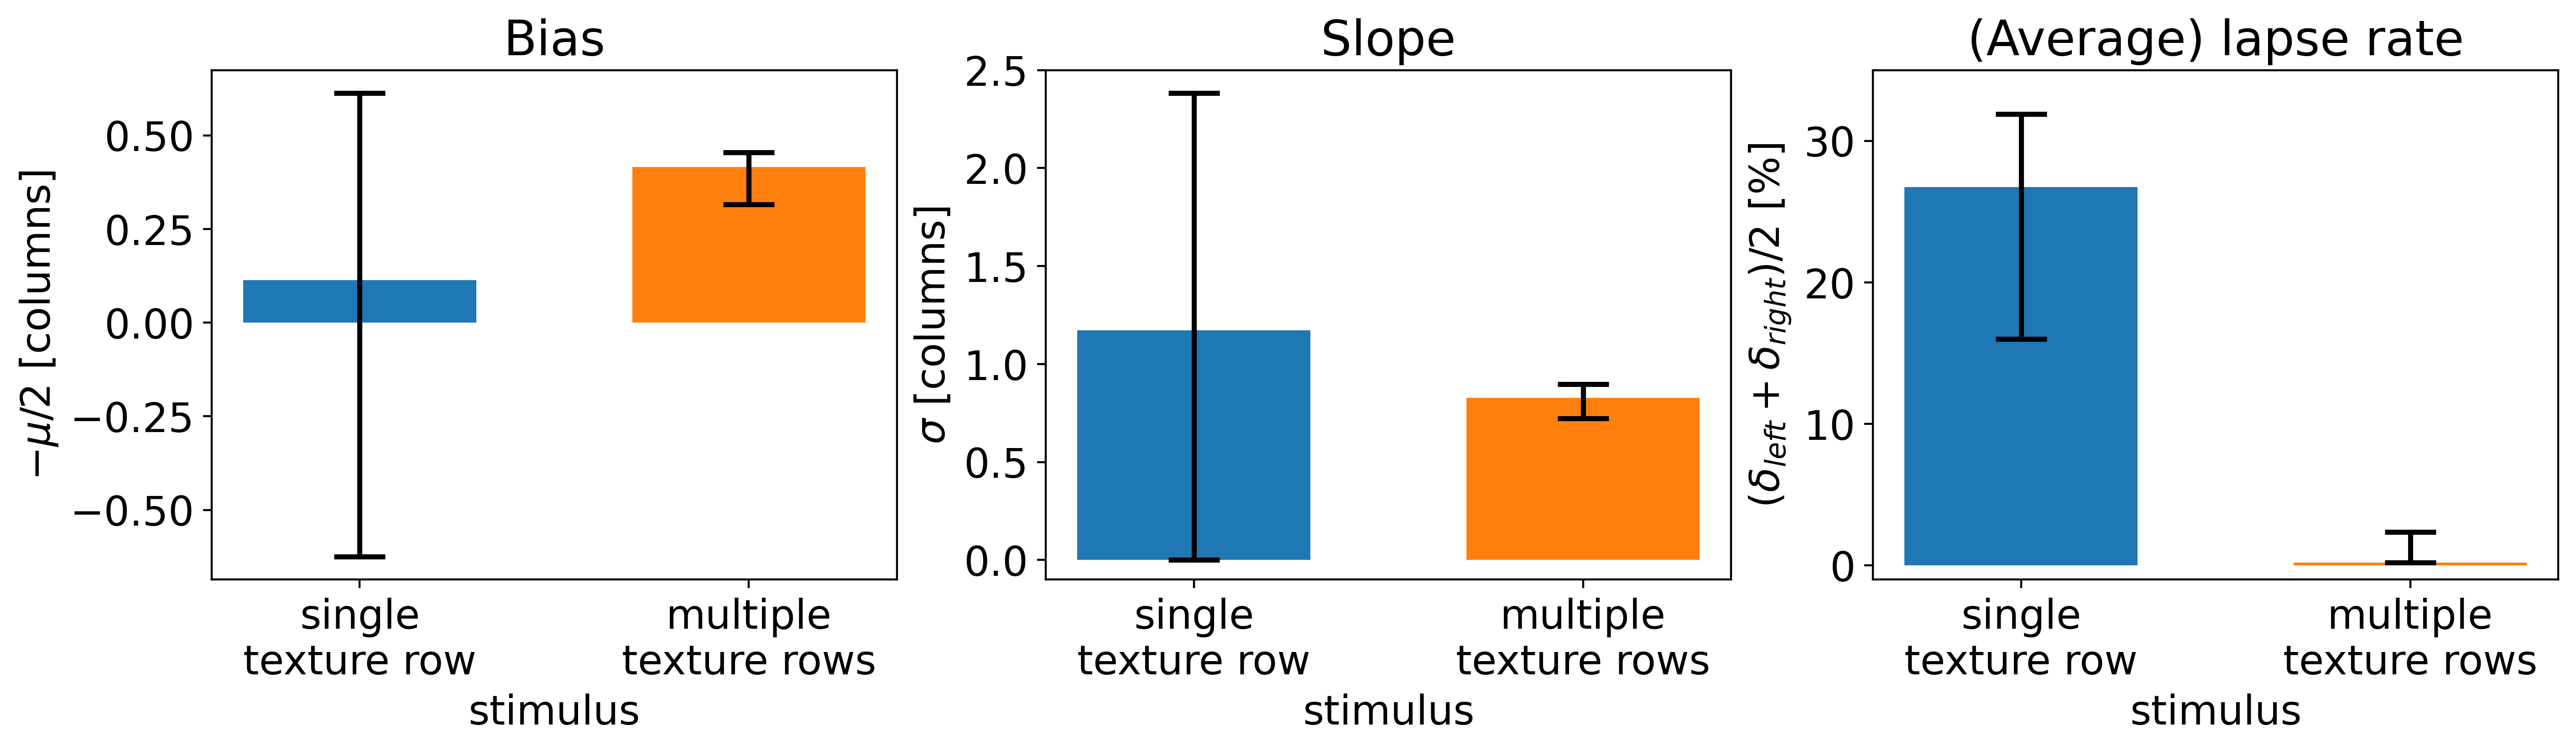

In [283]:
# plotting
labels = ["single\ntexture row", "multiple\ntexture rows"]
x = np.arange(len(labels))
width = 0.6
plt.rcParams.update({'font.size': 16})
fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True, dpi = 400)

# Bias
bias_mle = [-ML_results_2[1]['mean'][1] / 2, -ML_results_2[12]['mean'][1] / 2]
bias_ci_lower = [abs(ML_results_2[1]['mean'][2] - ML_results_2[1]['mean'][0]) / 2, abs(ML_results_2[12]['mean'][2] - ML_results_2[12]['mean'][0]) / 2] # the mean upper CI is the bias lower CI
bias_ci_upper = [abs(ML_results_2[1]['mean'][0] - ML_results_2[1]['mean'][1]) / 2, abs(ML_results_2[12]['mean'][0] - ML_results_2[12]['mean'][1]) / 2] # the mean lower CI is the mean lower CI
axes[0].bar(x, bias_mle, width, color=['C0','C1'], yerr=[bias_ci_lower, bias_ci_upper], error_kw=dict(elinewidth=2, capthick=2, capsize=10))
axes[0].set_xticks(x); axes[0].set_xticklabels(labels)
axes[0].set_ylabel(r'$-\mu / 2$ [columns]')
axes[0].set_xlabel("stimulus")
axes[0].set_title('Bias')

# Sensitivity
sens_mle = [ML_results_2[1]['std'][1], ML_results_2[12]['std'][1]]
sens_ci_lower = [abs(ML_results_2[1]['std'][0] - ML_results_2[1]['std'][1]), abs(ML_results_2[12]['std'][0] - ML_results_2[12]['std'][1])]
sens_ci_upper = [abs(ML_results_2[1]['std'][2] - ML_results_2[1]['std'][1]), abs(ML_results_2[12]['std'][2] - ML_results_2[12]['std'][1])]
axes[1].bar(x, sens_mle, width, color=['C0','C1'], yerr=[sens_ci_lower, sens_ci_upper], error_kw=dict(elinewidth=2, capthick=2, capsize=10))
axes[1].set_xticks(x); axes[1].set_xticklabels(labels)
axes[1].set_ylabel(r'$\sigma$ [columns]')
axes[1].set_title('Slope')
axes[1].set_xlabel("stimulus")
axes[1].set_ylim(-0.1, 2.5)

# Lapse rate
lapse_mle = [(ML_results_2[1]['lapse_rate_left'][1] + ML_results_2[1]['lapse_rate_right'][1]) / 2 * 100, (ML_results_2[12]['lapse_rate_left'][1] + ML_results_2[12]['lapse_rate_right'][1]) / 2 * 100 + 0.2] # + 0.2 just for visualization purposes
lapse_ci_lower = [(abs(ML_results_2[1]['lapse_rate_left'][0] - ML_results_2[1]['lapse_rate_left'][1]) + abs(ML_results_2[1]['lapse_rate_right'][0] - ML_results_2[1]['lapse_rate_right'][1])) / 2 * 100, (abs(ML_results_2[12]['lapse_rate_left'][0] - ML_results_2[12]['lapse_rate_left'][1]) + abs(ML_results_2[12]['lapse_rate_right'][0] - ML_results_2[12]['lapse_rate_right'][1])) / 2 * 100]
lapse_ci_upper = [(abs(ML_results_2[1]['lapse_rate_left'][2] - ML_results_2[1]['lapse_rate_left'][1]) + abs(ML_results_2[1]['lapse_rate_right'][2] - ML_results_2[1]['lapse_rate_right'][1])) / 2 * 100, (abs(ML_results_2[12]['lapse_rate_left'][2] - ML_results_2[12]['lapse_rate_left'][1]) + abs(ML_results_2[12]['lapse_rate_right'][2] - ML_results_2[12]['lapse_rate_right'][1])) / 2 * 100] 
axes[2].bar(x, lapse_mle, width, color=['C0','C1'], yerr=[lapse_ci_lower, lapse_ci_upper], error_kw=dict(elinewidth=2, capthick=2, capsize=10))
axes[2].set_xticks(x); axes[2].set_xticklabels(labels)
axes[2].set_ylabel(r'$(\delta_{left} + \delta_{right}) / 2$ [%]')
axes[2].set_title('(Average) lapse rate')
axes[2].set_xlabel("stimulus")
axes[2].set_ylim(-1, 35)

plt.show()

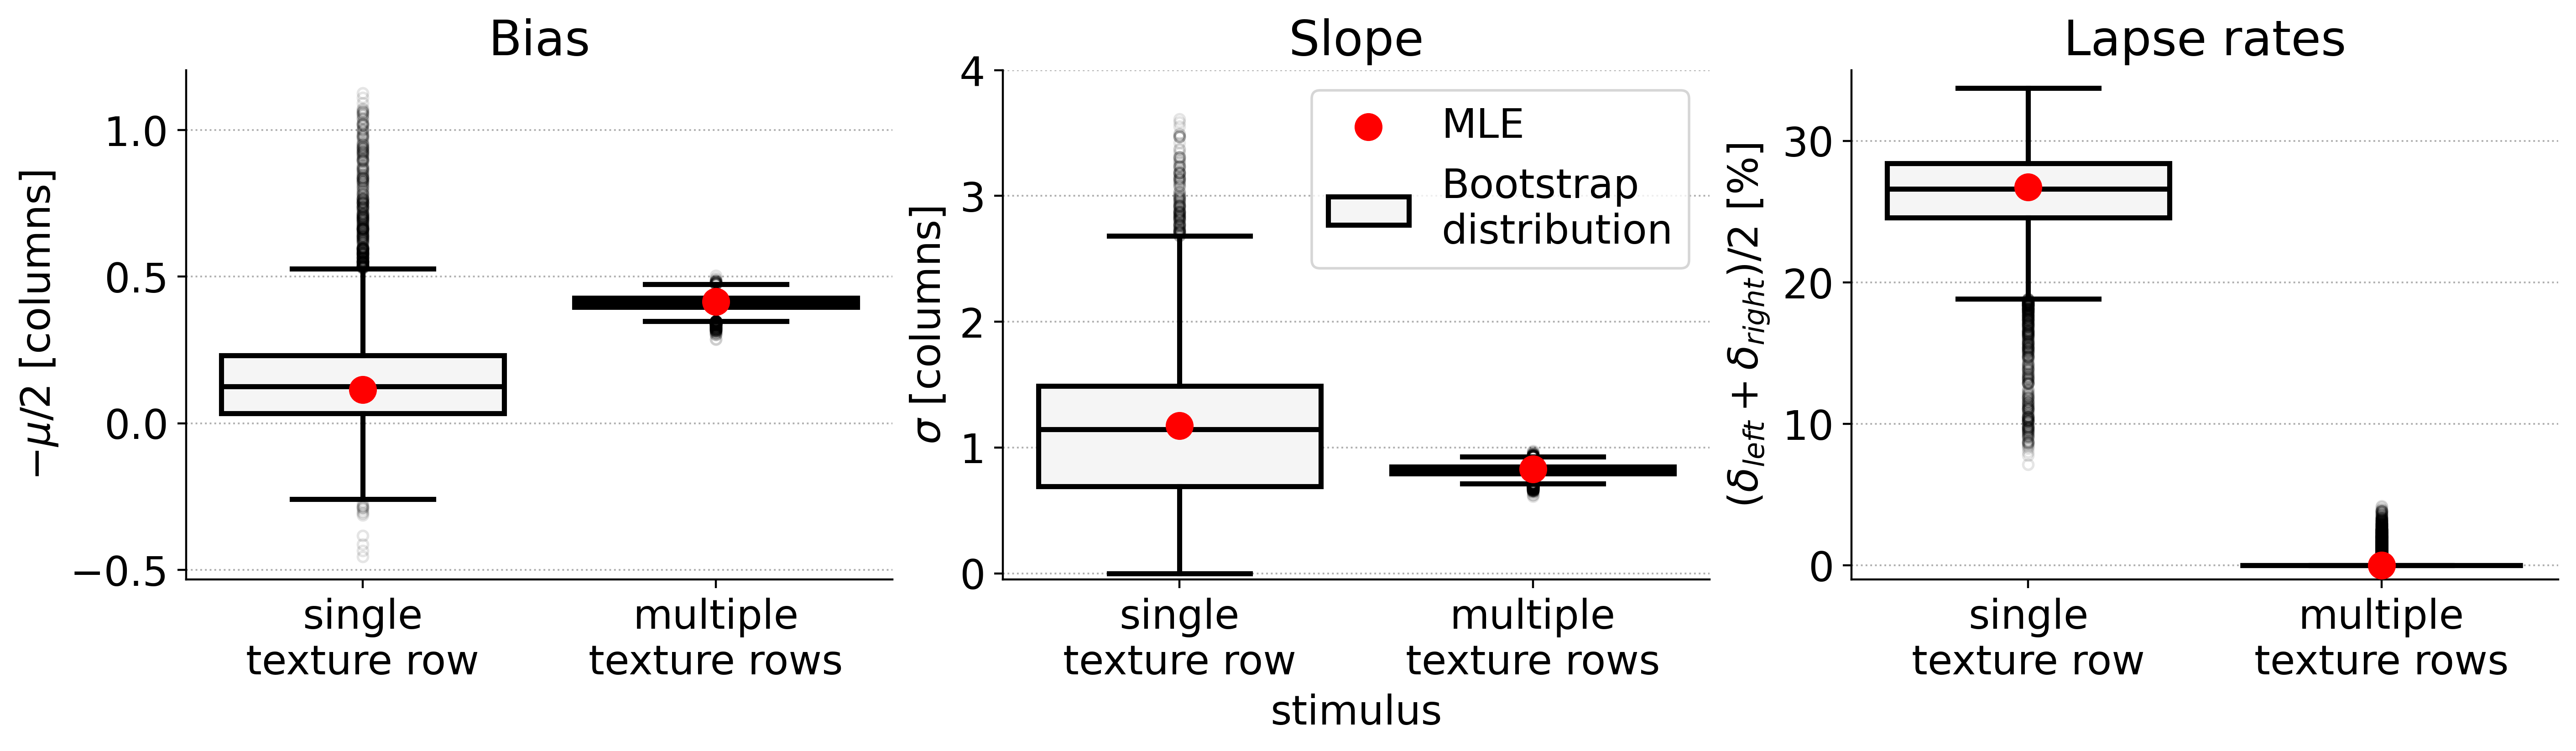

In [316]:
labels = ["single\ntexture row", "multiple\ntexture rows"]
x = np.arange(len(labels))
plt.rcParams.update({'font.size': 16})

# get bootstrap arrays
boot1 = ML_results_2[1]['bootstrap_params']   # shape (n_boots, 4)
boot12 = ML_results_2[12]['bootstrap_params']

# build bootstrap distributions for plotting
bias_data = [ -0.5 * boot1[:, 0], -0.5 * boot12[:, 0] ]                     # bias = -mu/2
sens_data = [ boot1[:, 1], boot12[:, 1] ]                                   # σ (slope)
lapse_data = [ (boot1[:, 2] + boot1[:, 3]) / 2 * 100,                        # avg (left+right)/2 *100
               (boot12[:, 2] + boot12[:, 3]) / 2 * 100 ]

# compute MLE markers
bias_mle = [ -ML_results_2[1]['mean'][1] / 2, -ML_results_2[12]['mean'][1] / 2 ]
sens_mle = [ ML_results_2[1]['std'][1], ML_results_2[12]['std'][1] ]
lapse_mle = [ (ML_results_2[1]['lapse_rate_left'][1] + ML_results_2[1]['lapse_rate_right'][1]) / 2 * 100,
              (ML_results_2[12]['lapse_rate_left'][1] + ML_results_2[12]['lapse_rate_right'][1]) / 2 * 100 ]

fig, axes = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True, dpi=400)

boxprops = dict(linewidth=2, facecolor='whitesmoke')
medianprops = dict(linewidth=2, color='black')
whiskerprops = dict(linewidth=2)
capprops = dict(linewidth=2)
flierprops = dict(marker='o', markersize=4, alpha=0.1)

# Bias
axes[0].scatter(x, bias_mle, color='red', marker='o', s=100, zorder=3, label='MLE')
axes[0].boxplot(bias_data, positions=x, widths=0.8, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, label='Bootstrap\ndistribution')
axes[0].set_xticks(x); axes[0].set_xticklabels(labels)
axes[0].set_ylabel(r'$-\mu / 2$ [columns]')
axes[0].set_title('Bias')

# Sensitivity (σ)
axes[1].scatter(x, sens_mle, color='red', marker='o', s=100, zorder=3, label='MLE')
axes[1].boxplot(sens_data, positions=x, widths=0.8, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, label='Bootstrap\ndistribution')
axes[1].set_xticks(x); axes[1].set_xticklabels(labels)
axes[1].set_ylabel(r'$\sigma$ [columns]')
axes[1].set_title('Slope')
axes[1].set_xlabel('stimulus')
axes[1].set_ylim(-0.05, 4.0)
axes[1].legend()

# Lapse rate (avg left and right)
axes[2].scatter(x, lapse_mle, color='red', marker='o', s=100, zorder=3, label='MLE')
axes[2].boxplot(lapse_data, positions=x, widths=0.8, patch_artist=True,
                boxprops=boxprops, medianprops=medianprops,
                whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, label='Bootstrap\ndistribution')
axes[2].set_xticks(x); axes[2].set_xticklabels(labels)
axes[2].set_ylabel(r'$(\delta_{left} + \delta_{right}) / 2$ [%]')
axes[2].set_title('Lapse rates')
axes[2].set_ylim(-1, 35)


for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle=':', linewidth=0.7)

plt.show()